In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import  pandas as pd
from scipy.optimize import curve_fit
from learning_lidar.utils import utils
from learning_lidar.utils.global_settings import eps
def sigmoid(x, x0=0,A = 0 , K = 1,B=1, v=0.4,C=1,Q=1):
    y =A+(K-A)/(eps+(C + Q*np.exp(-B*(x-x0)))**(v))
    return (y)
from datetime import datetime, timedelta
import learning_lidar.preprocessing.preprocessing_utils as prep_utils
import learning_lidar.utils.vis_utils as vis_utils
vis_utils.set_visualization_settings()
from learning_lidar.utils.proc_utils import Bezier
import learning_lidar.utils.global_settings as gs
import seaborn as sns
sns.set_palette(sns.color_palette('bright'))
from typing import Union

### Play ground with a parametric curve of a generalized Sigmoid curve to represent the overlap function
### $y(x)=A+\frac{A-K}{(C+Q\cdot\exp[-B(t-x_0)])^{\nu}}$

C:\Users\addalin\.conda\envs\lidar\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[9.23178648e-03 1.03054874e-13 1.00179283e+00 1.00000000e+00
 1.00000000e+00 1.00179283e+00 9.92587051e-01]


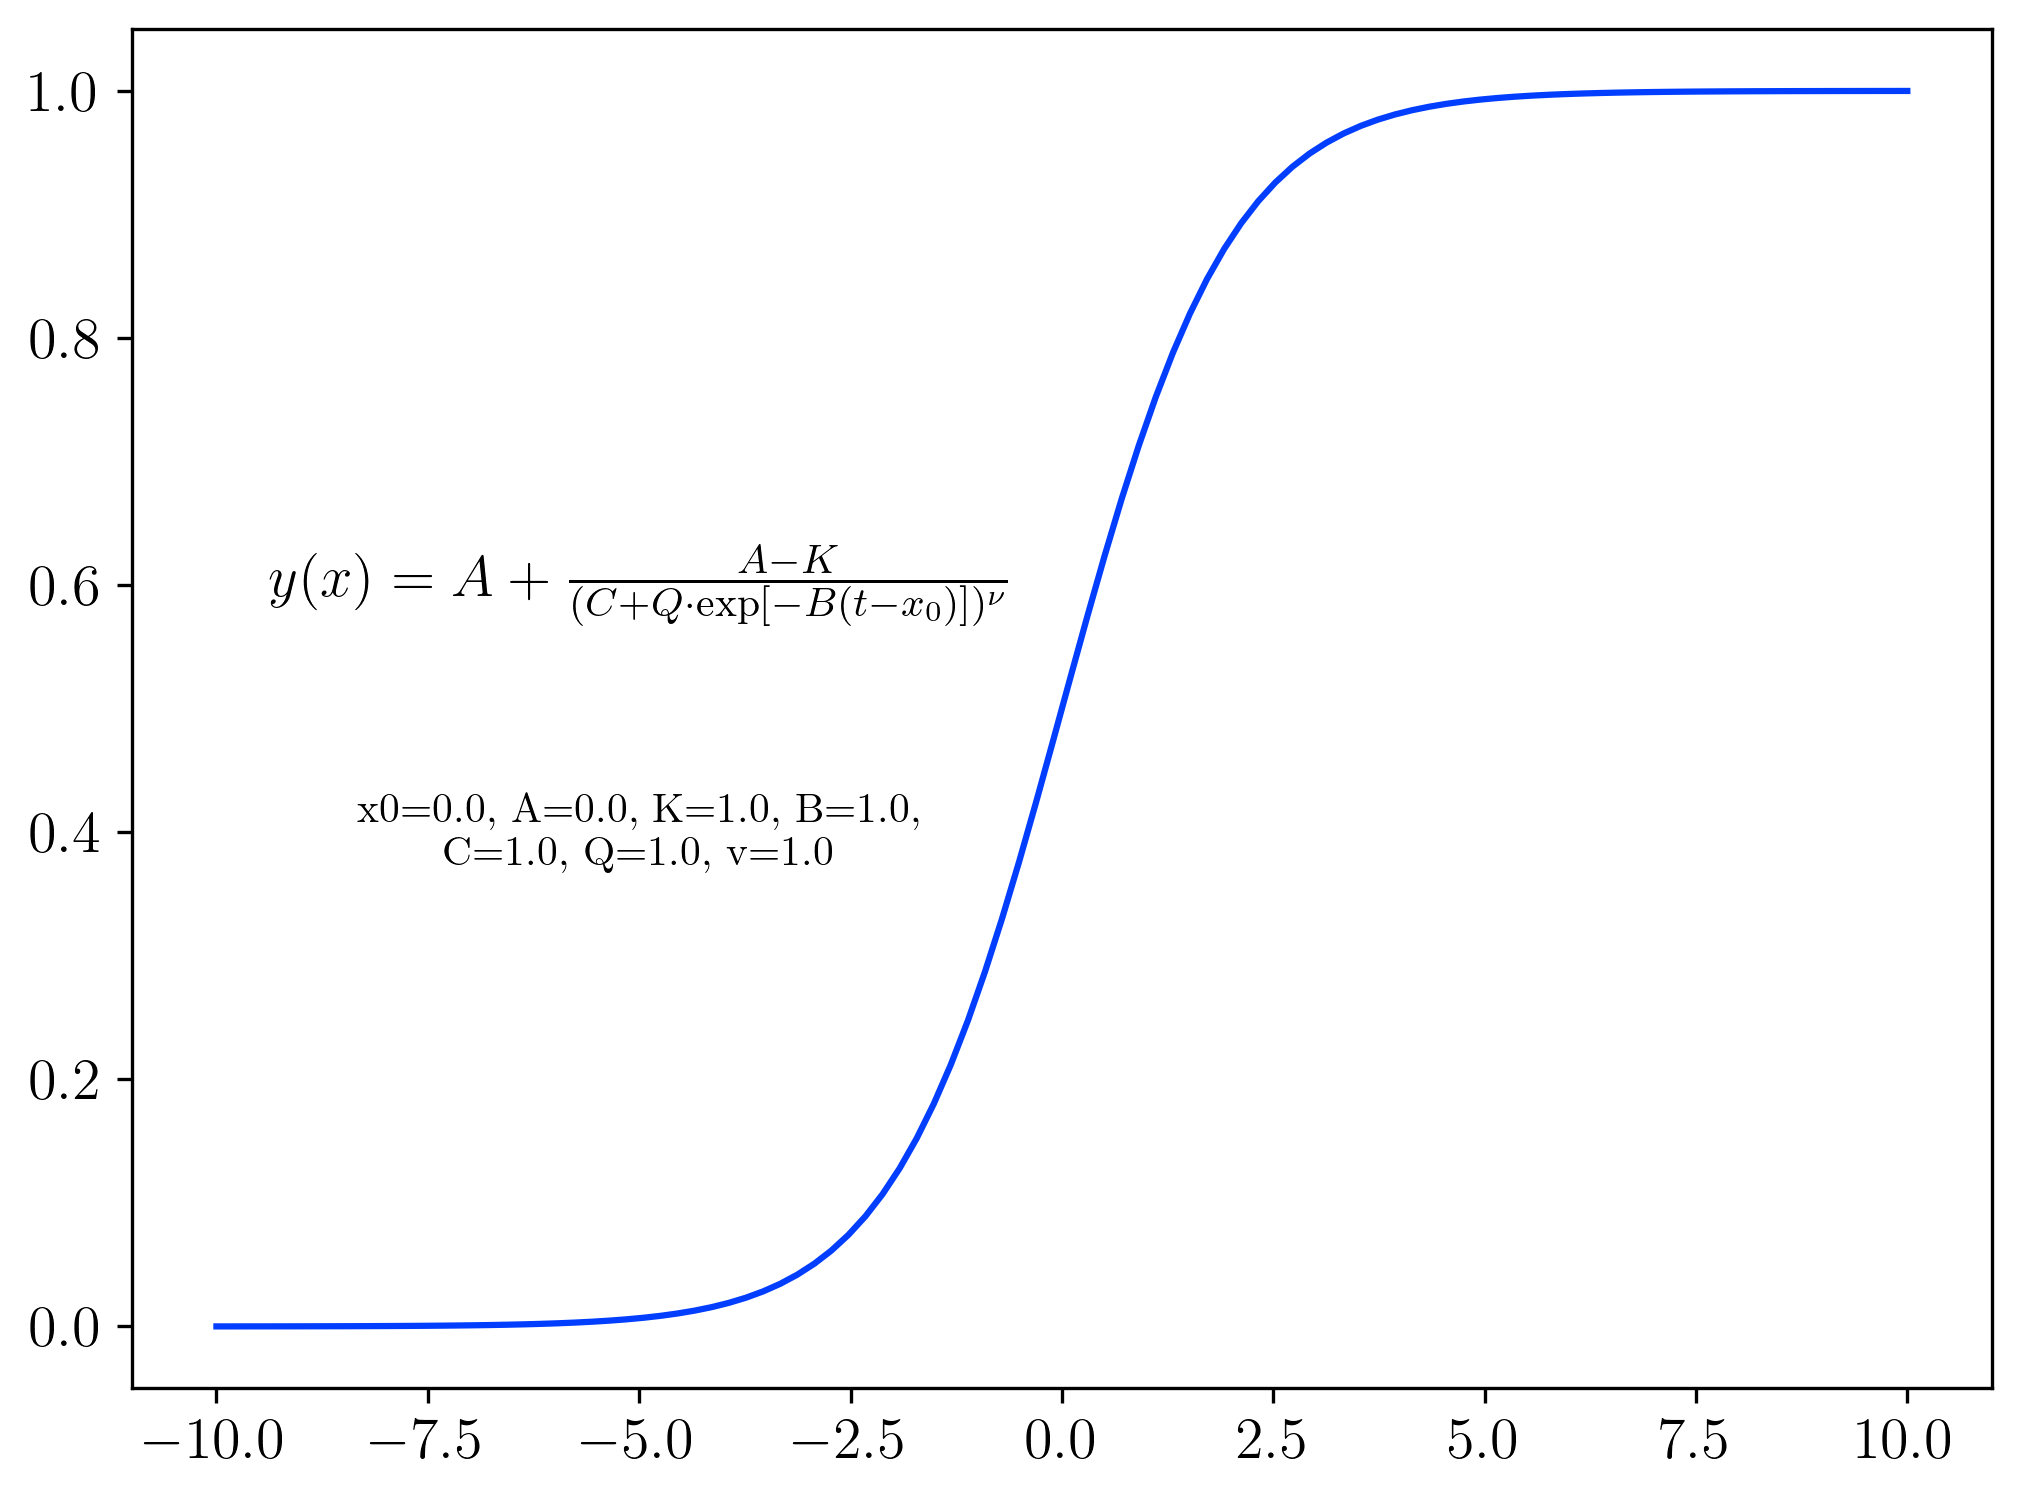

In [2]:
x =np.linspace(start=-10,stop=10,num=100)
y =sigmoid(x,x0=0,A=0,K=1, B=1, v=1,C=1,Q=1)

mean_ind = np.argmin(np.abs(y-y.mean()))
x0 = 0 #x[mean_ind]
A0  = y.min()
K0 = y.max()- y.min()
v0 = 1
Q0 = 1 #-1 + (1/y[mean_ind])**(v0)
B0 = 1
C0 = 1
p0 = [x0,A0,K0, B0,v0, C0,Q0]
txt_e = r'$y(x)=A+\frac{A-K}{(C+Q\cdot\exp[-B(t-x_0)])^{\nu}}$'

popt, pcov = curve_fit(sigmoid, x, y,p0)#, method='dogbox')
print(popt)
info_vals= f'x0={p0[0]:0.1f}, A={p0[1]:0.1f}, K={p0[2]:0.1f}, B={p0[3]:0.1f},\n' +\
           f'C={p0[5]:0.1f}, Q={p0[6]:0.1f}, v={p0[4]:0.1f}'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(x,y)
ax.text(-5, 0.6, txt_e, fontsize=14,
         verticalalignment = 'center', horizontalalignment = 'center')
ax.text(-5, 0.4, info_vals, fontsize=10,
         verticalalignment = 'center', horizontalalignment = 'center')
#plt.plot(x,sigmoid(x,*popt),'--')
plt.show()

### Exploring overlap functions from Holger

### Load the datasets from Excel file

In [5]:
data_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))), 'data')
overlap_fn = os.path.join(data_folder,'overlap','Overlaps.xlsx')

xls = pd.ExcelFile(overlap_fn)
overlaps = []
for ind,sheet_name in enumerate(xls.sheet_names[0:-1]):
    df = xls.parse(sheet_name, skiprows=2,index_col='Height [m]') #sheet_to_df_map[sheet_name]
    df_info = xls.parse(sheet_name,nrows=1) #info_map[sheet_name]
    cols = df.columns.tolist()
    new_cols = [int(col.split('Overlap_')[1]) for col in cols]
    attrs ={}
    for key in df_info.keys():
        attrs.update(dict({key:df_info[key][0]}))
    overlap_ds = xr.Dataset(data_vars={'Overlap': (('Height','Wavelength'),df.values,attrs)},
                        coords={'Height':1e-3*df.index.values, 'Wavelength':new_cols,'index':ind})
    overlap_ds.Height.attrs= {'units':r'$\rm km$'}
    overlaps.append(overlap_ds)

ValueError: Index Height [m] invalid

### Fitting a sigmoid curve to the overlap function.
> Note: The fit is being done on "fixed" values.
> The values that are too noisy, above the overlap height set to 1.
#### The maximum overlap height is 1[km] (actually is should be ~700[m], but I set it to 1[km] to have a more realistic measurements) above this height the overlap should be 1.

In [ ]:
height_one = 1.000
end_height = 3.500
error_rate = 0.05
popts = []
for cur_overlap in overlaps[1:]:
    #cur_overlap= overlaps[4]
    #cur_overlap = cur_overlap.drop('index')
    [b0,b1] = np.argmin(np.abs (cur_overlap.Overlap.Height.values - height_one)) ,np.argmin(np.abs (cur_overlap.Overlap.Height.values - end_height))
    y_orig = cur_overlap.Overlap.sel(Height = slice(0,end_height))
    y_fixed  = y_orig.copy(deep=True)
    mean_val = y_fixed[b0:b1].values.mean()
    y_fixed.attrs={'long_name':'fixed'}
    y_orig.attrs={'long_name':'orig'}
    y_fixed[b0:b1] = (y_fixed[b0:b1]).where(y_orig<1*(1+error_rate)).where(y_orig>1*(1-error_rate)).fillna(1)

    y_fit = y_fixed.copy(deep=True)
    y_fit.attrs={'long_name':'fit'}
    mean_inds = np.argmin(np.abs(y_fixed.values-y_fixed.values.mean()),axis=0)
    info_vals=[]

    for ind,wav in enumerate(y_fixed.Wavelength.values):
        mean_ind = mean_inds[ind]
        x = y_fixed.Height.values
        y = y_fixed.sel(Wavelength = wav).values
        x0 = x[mean_ind]
        A0  = y.min()
        K0 = y.max()- y.min()
        v0 = 1
        B0 = 1
        C0 = 1
        Q0 = -1 + (1/y[mean_ind])**(v0)
        p0  = [ x0,A0,K0, B0, v0,C0,Q0]
        popt, pcov = curve_fit(sigmoid, x, y,p0, method='trf') # trf: using Trust Region Reflective algorithm
        popts.append(popt)
        fitsig_i = sigmoid(x,*popt)
        #info_vals.append(r'$\rm y(x)=A+\frac{A-K}{\bigg(C+Q\cdot\exp\big[-B(t-x_0)\big]\bigg)^{\nu}}\\$'+
        #                 rf'$\rm x_0={popt[0]:0.2f}, A={popt[1]:0.2f}, K={popt[2]:0.2f}, B={popt[3]:0.2f},\\$'+
        #                 rf'$\rm  C={popt[5]:0.2f}, Q={popt[6]:0.2f}, \nu={popt[4]:0.2f}$')
        info_vals.append(f'x0={popt[0]:0.2f}, A={popt[1]:0.2f}, K={popt[2]:0.2f}, B={popt[3]:0.2f},\n'+
                         f'C={popt[5]:0.2f}, Q={popt[6]:0.2f}, v={popt[4]:0.2f}')

        fitsig_i[fitsig_i<0] = 0
        y_fit.sel(Wavelength = wav)[:] = fitsig_i

    txt_e = r'$y(x)=A+\frac{A-K}{(C+Q\cdot\exp[-B(t-x_0)])^{\nu}}$'
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    for wav,info,ax in zip(y_orig.Wavelength.values, info_vals, axes.ravel()):
        y_orig.sel(Wavelength=wav).plot(label = y_orig.long_name,ax=ax)
        y_fixed.sel(Wavelength=wav).plot(label = y_fixed.long_name,ax=ax)
        y_fit.attrs = {'long_name':'fit', 'info':info}
        y_fit.sel(Wavelength=wav).plot(label = y_fit.long_name,ax=ax)

        ax.text(end_height*.55, 0.6, txt_e, fontsize=14,
                 verticalalignment = 'center', horizontalalignment = 'center')
        ax.text(end_height*.55, 0.4, info, fontsize=10,
                 verticalalignment = 'center', horizontalalignment = 'center')
        ax.legend()
        ax.set_ylabel('Overlap')
    plt.show()

### Calculate the sigmoid parameters stats

In [6]:
popts_val = np.array(popts)
popt_mean = popts_val.mean(axis=0)
popt_std = popts_val.std(axis=0)
popt_min = popts_val.min(axis=0)
popt_max = popts_val.max(axis=0)
params  = [r'$\rm x_0$',r'$\rm A$', r'$\rm K$', r'$\rm B$', r'$\rm \nu$', r'$\rm C$', r'$\rm Q$' ]
cols = ['param', 'mean','std','min','max']
df_stats = pd.DataFrame(data=[params, popt_mean,popt_std,popt_min,popt_max], index=cols).T
df_stats


NameError: name 'popts' is not defined

In [7]:
station = gs.Station('haifa')
heigths = station.get_height_bins_values()



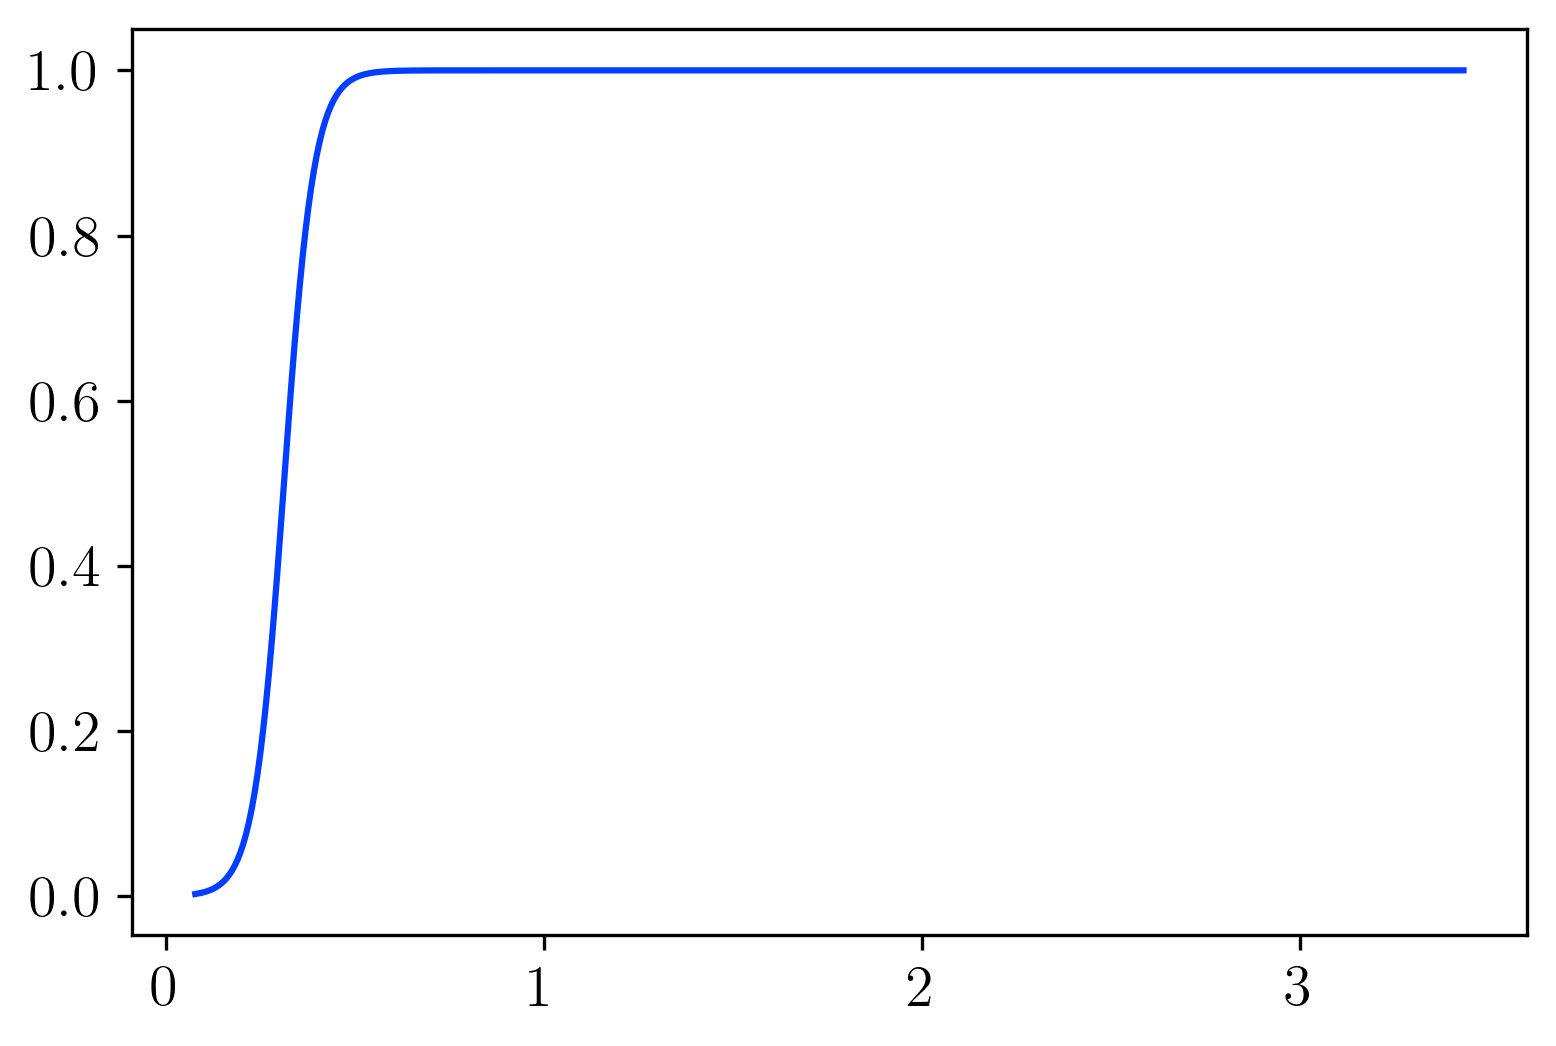

In [8]:
X0 = 0.35
A = 0
K = 1
B = 25
V = 1.0
C  = 1.0
Q = 0.4
mean_p0 = [X0,A,K,B,V,C,Q]
#sig = A+(K-A)/(eps+(C + Q*np.exp(-B*(heigths-x0)))**(v))
sig = sigmoid(heigths,*mean_p0)
plt.plot(heigths[0:450], sig[0:450])
plt.show()

### Testing the affect of the changing each parameter

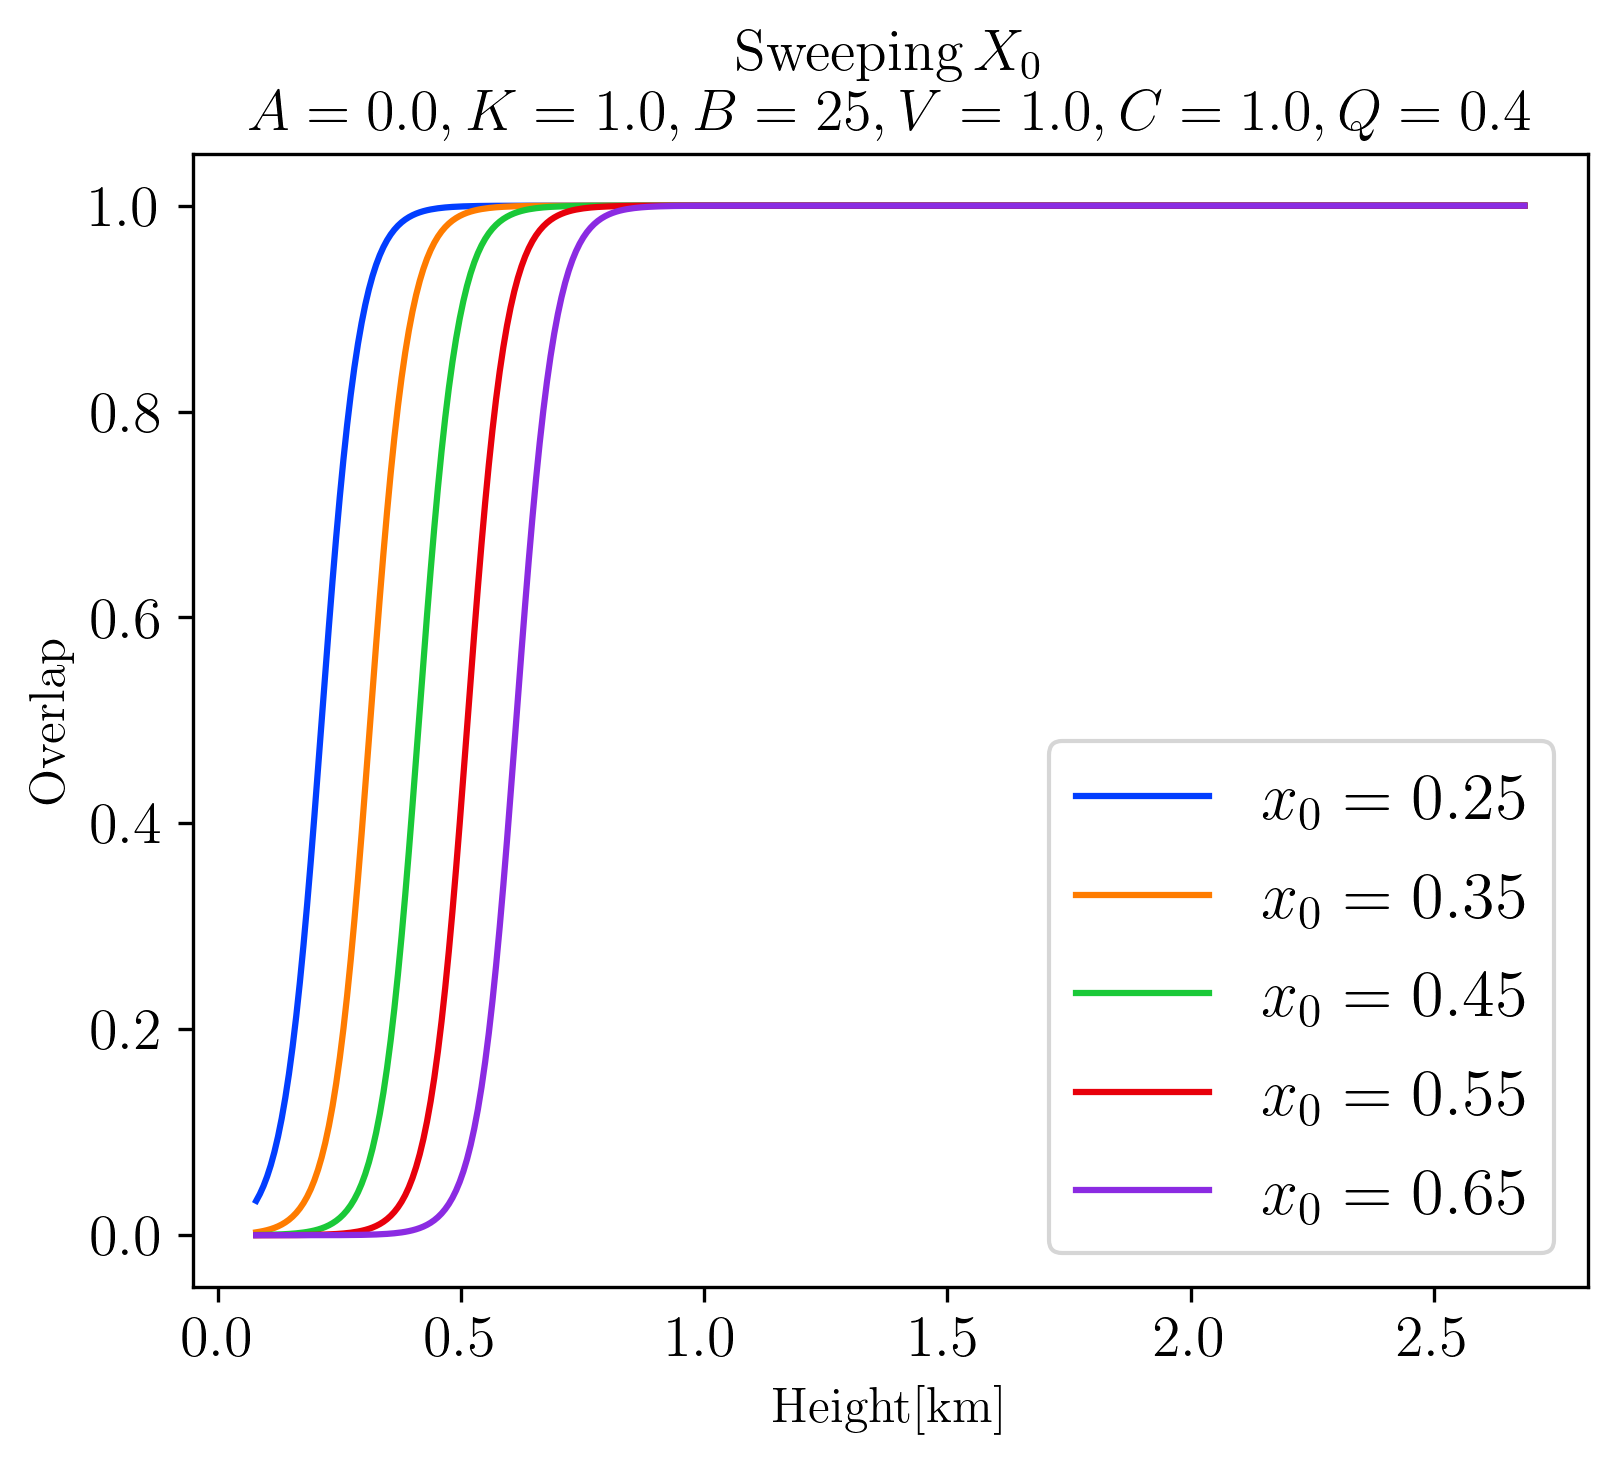

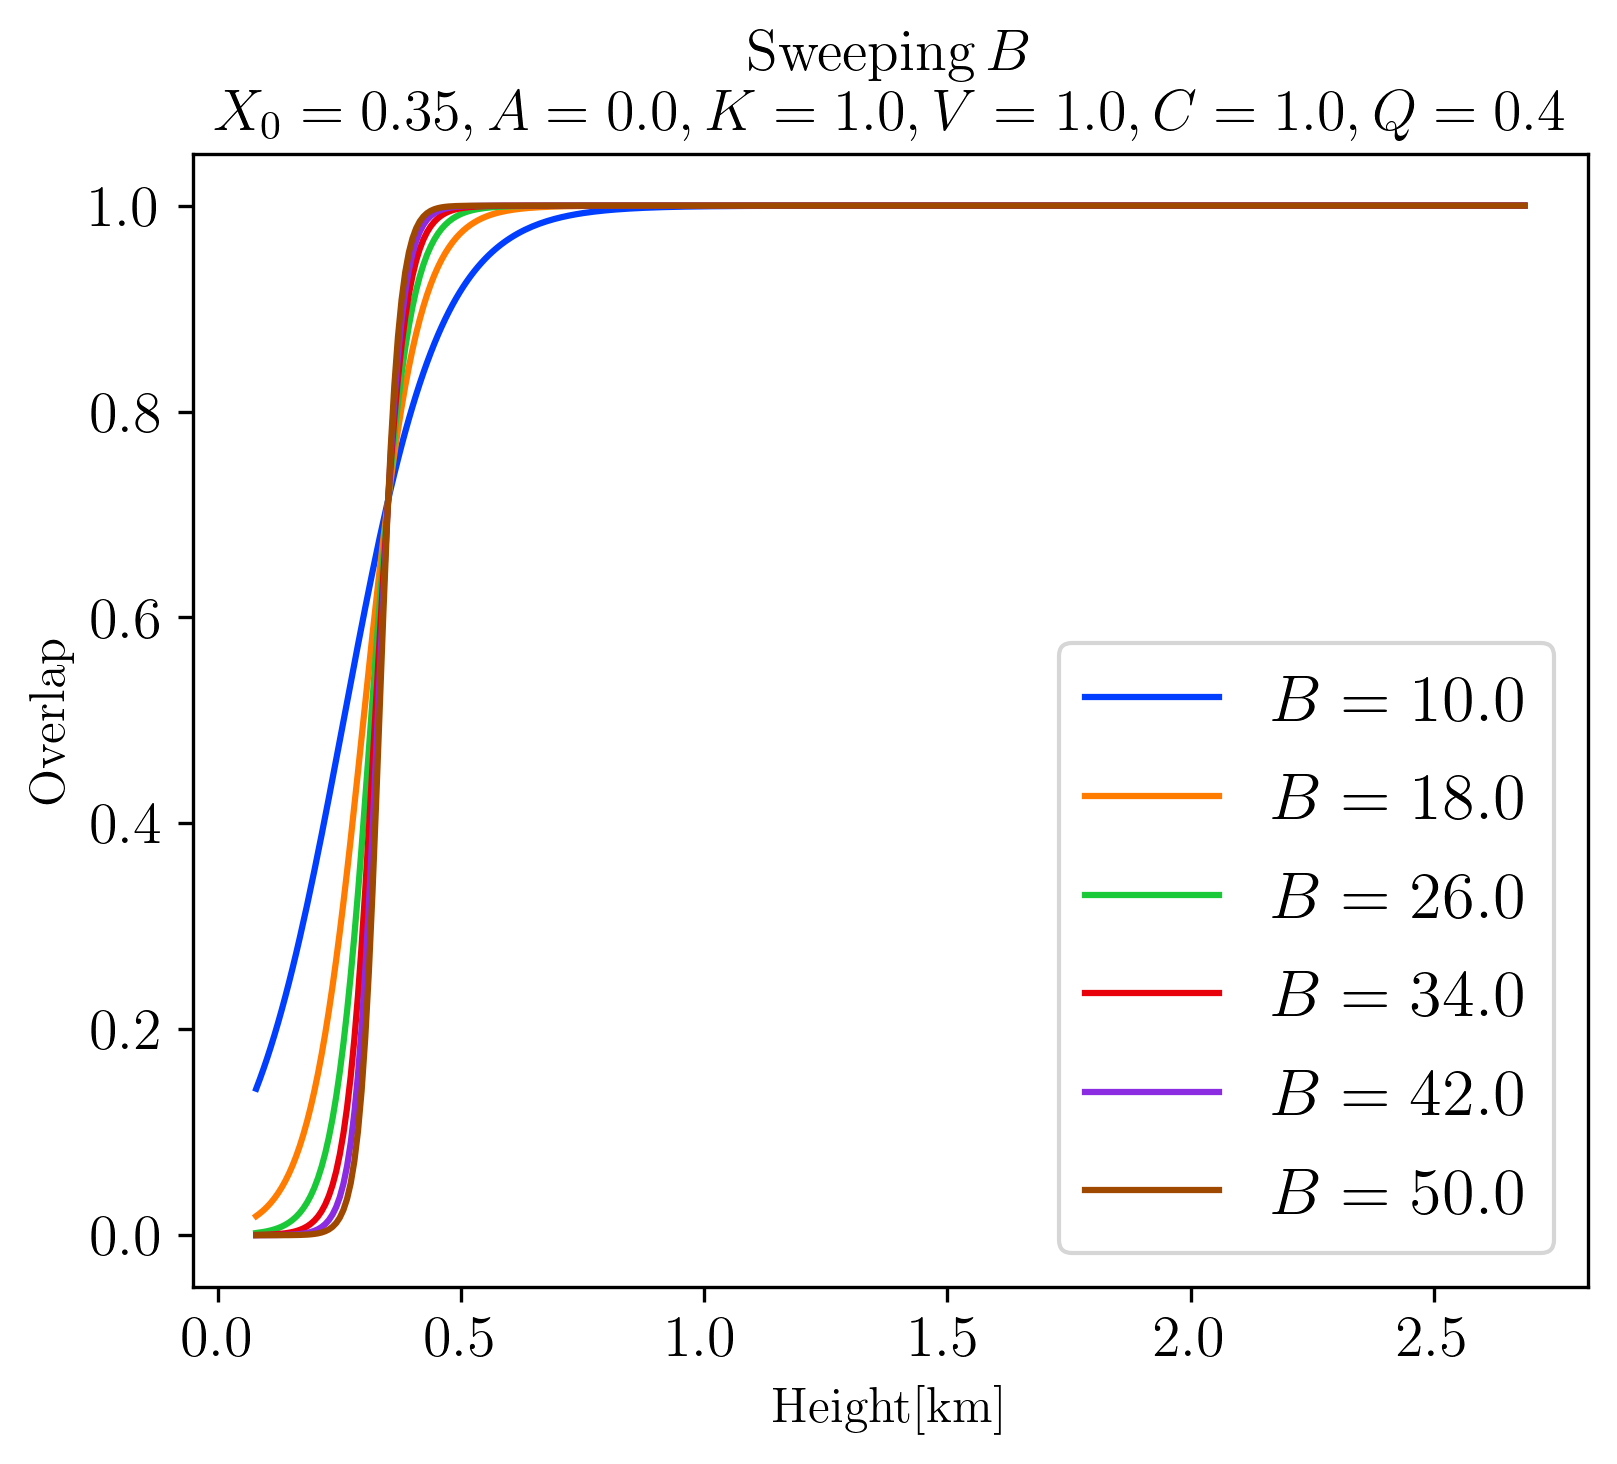

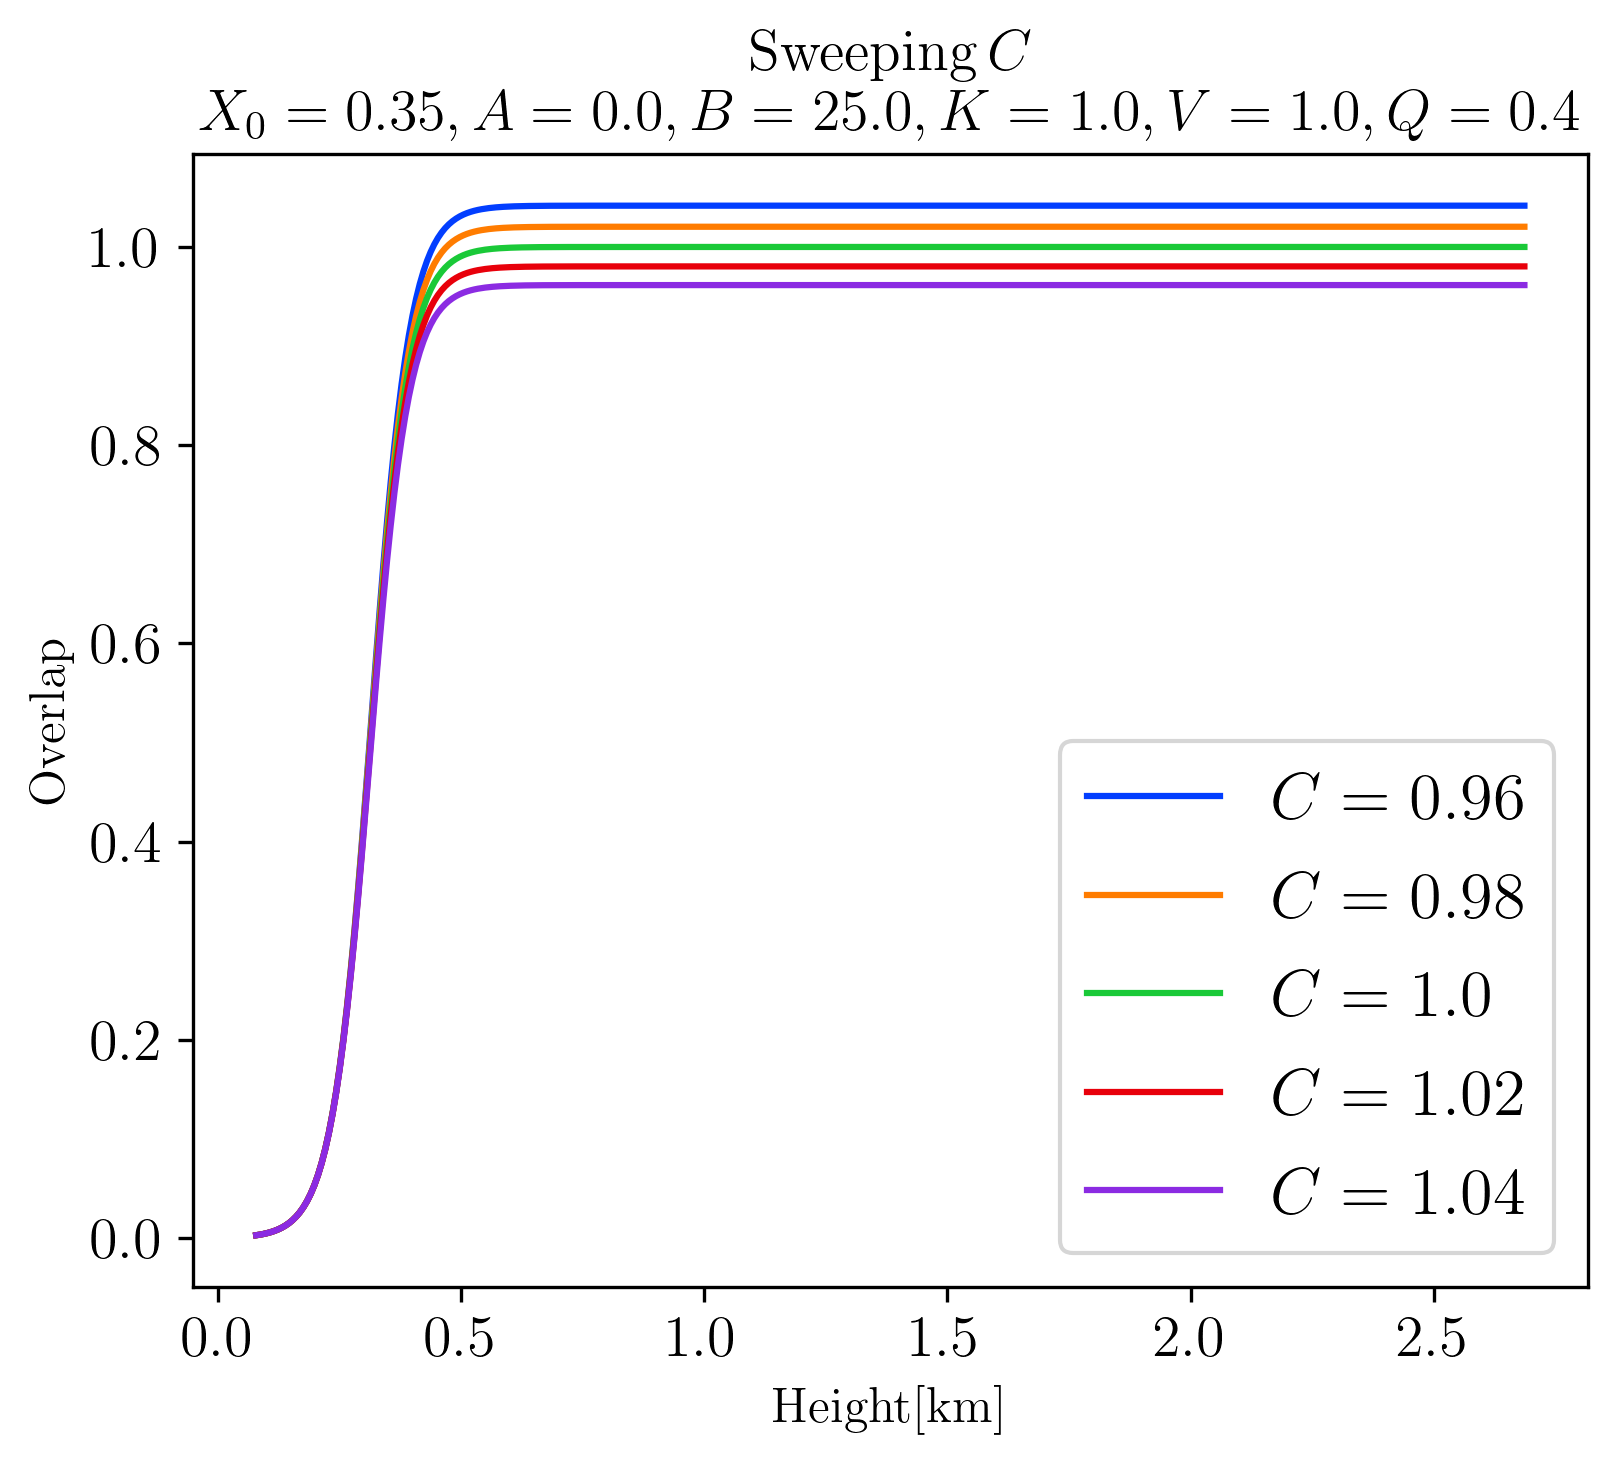

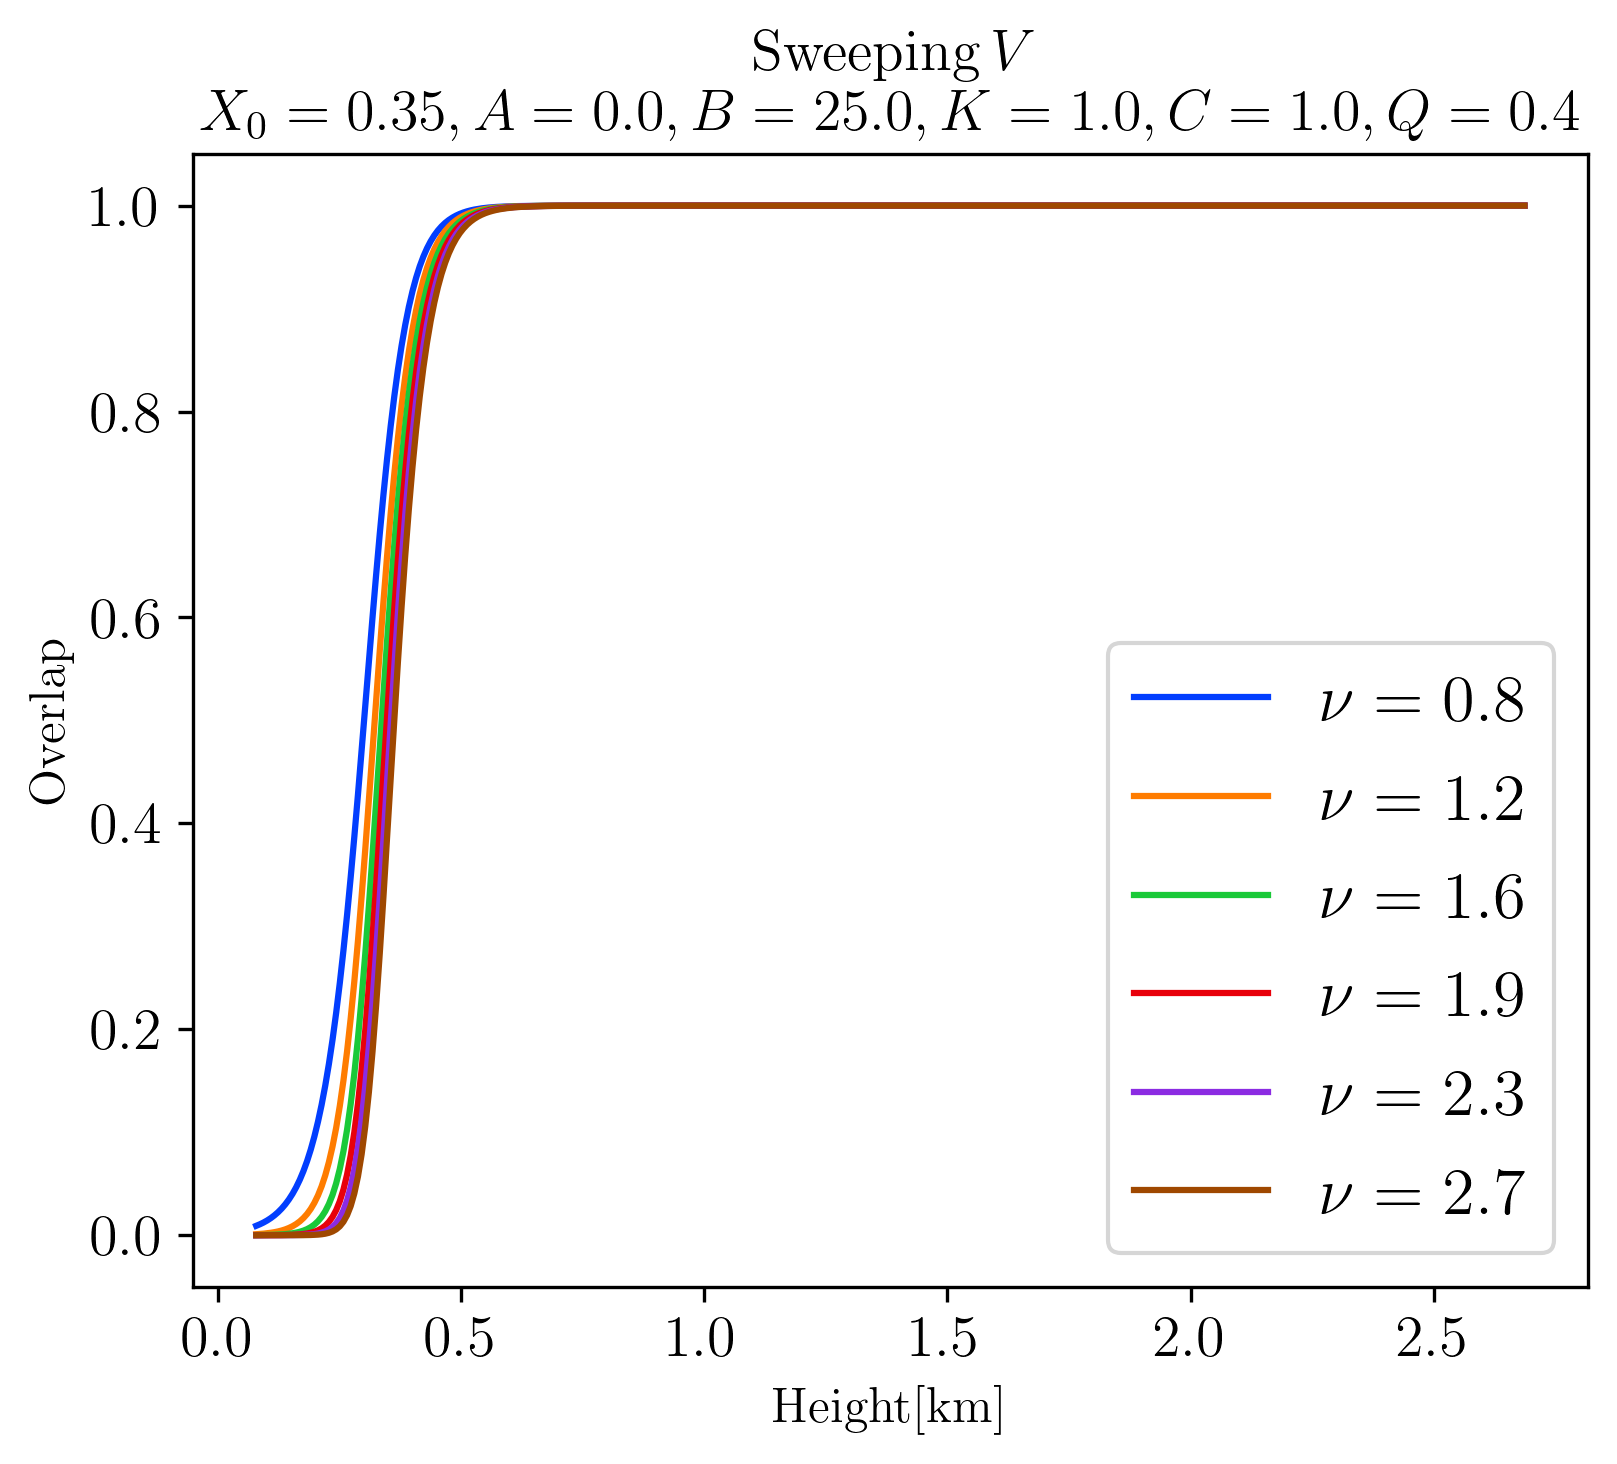

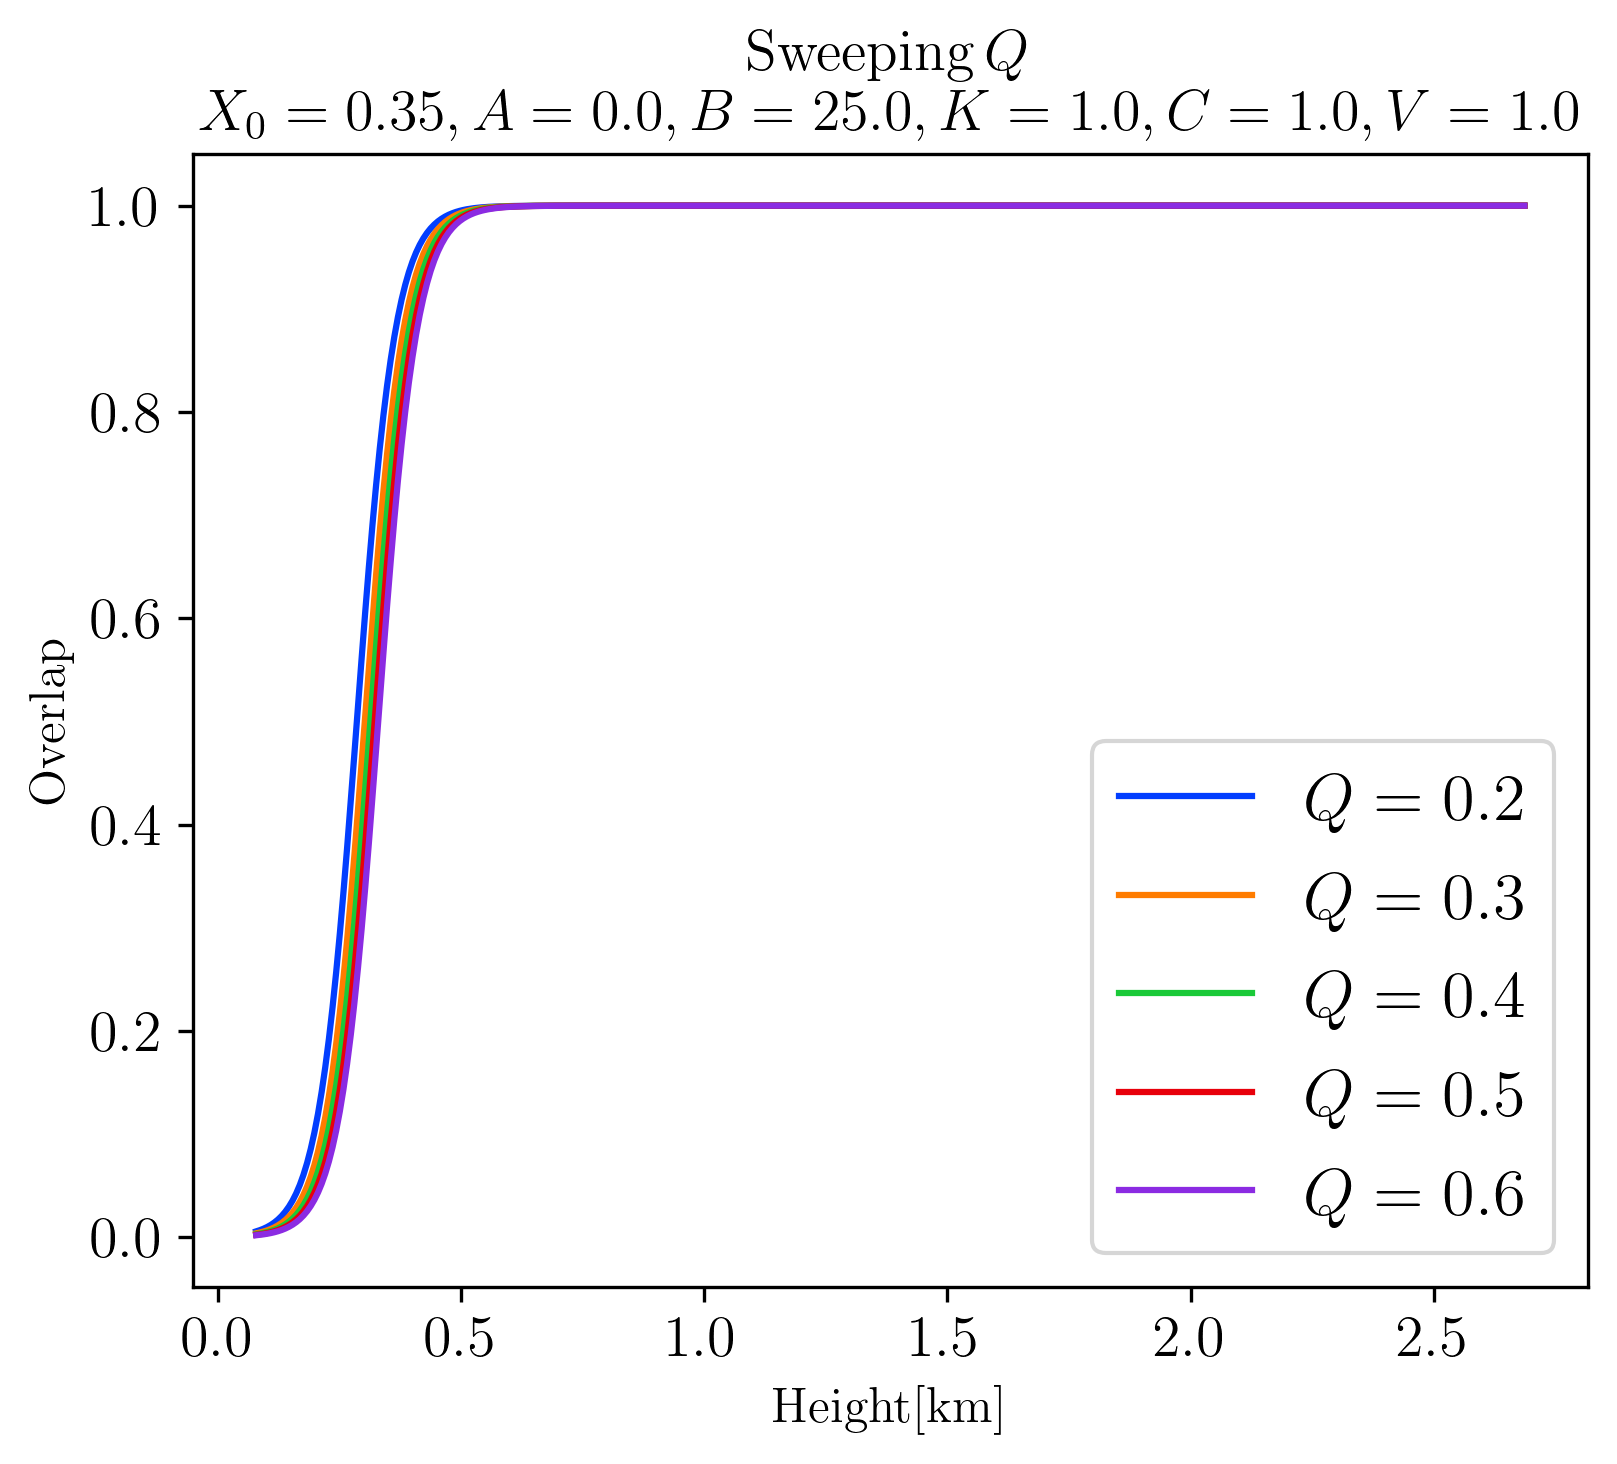

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
X0s = np.linspace(start= 0.25, stop=0.65,endpoint=True, num=5)
stitle = rf'Sweeping$\,X_0$'+'\n'+ rf'$ A = {A:.1f}, K = {K:.1f}, B = {B}, V = {V}, C = {C}, Q = {Q}$'
for x0 in X0s:
    mean_p0 = [x0,A,K,B,V,C,Q]
    sig = sigmoid(heigths,*mean_p0)
    ax.plot(heigths[0:350], sig[0:350], label = rf'$x_0={x0:.2}$')
    ax.set_title(stitle,fontsize= 14)
    ax.set_xlabel(r'$\rm Height[km]$',fontsize= 12)
    ax.set_ylabel('Overlap',fontsize= 12)
plt.legend()
plt.show()
# %%
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
stitle = rf'Sweeping$\,B$'+'\n'+ rf'$ X_0 = {X0:.2f}, A = {A:.1f}, K = {K:.1f}, V = {V}, C = {C}, Q = {Q}$'
Bs = np.linspace(start= 10, stop=50,endpoint=True, num=6)
for b in Bs:
    mean_p0 = [X0,A,K,b,V,C,Q]
    sig = sigmoid(heigths,*mean_p0)
    ax.plot(heigths[0:350], sig[0:350], label = rf'$B={b:.1f}$')
    ax.set_title(stitle,fontsize= 14)
    ax.set_xlabel(r'$\rm Height[km]$',fontsize= 12)
    ax.set_ylabel('Overlap',fontsize= 12)
plt.legend()
plt.show()

# %%
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
stitle = rf'Sweeping$\,C$'+'\n'+ rf'$ X_0 = {X0:.2f}, A = {A:.1f},B = {B:.1f}, K = {K:.1f}, V = {V}, Q = {Q}$'
Cs = np.linspace(start= 0.96, stop=1.04,endpoint=True, num=5)
for c in Cs:
    mean_p0 = [X0,A,K,B,V,c,Q]
    sig = sigmoid(heigths,*mean_p0)
    ax.plot(heigths[0:350], sig[0:350], label = rf'$C={c:.3}$')
    ax.set_title(stitle,fontsize= 14)
    ax.set_xlabel(r'$\rm Height[km]$',fontsize= 12)
    ax.set_ylabel('Overlap',fontsize= 12)
plt.legend()
plt.show()
# %%
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
stitle = rf'Sweeping$\,V$'+'\n'+ rf'$ X_0 = {X0:.2f}, A = {A:.1f},B = {B:.1f}, K = {K:.1f}, C = {C}, Q = {Q}$'
Vs = np.linspace(start= 0.8, stop=2.7,endpoint=True, num=6)
for v in Vs:
    mean_p0 = [X0,A,K,B,v,C,Q]
    sig = sigmoid(heigths,*mean_p0)
    ax.plot(heigths[0:350], sig[0:350], label = rf'$\nu={v:.2}$')
    ax.set_title(stitle,fontsize= 14)
    ax.set_xlabel(r'$\rm Height[km]$',fontsize= 12)
    ax.set_ylabel('Overlap',fontsize= 12)
plt.legend()
plt.show()

# %%
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
stitle = rf'Sweeping$\,Q$'+'\n'+ rf'$ X_0 = {X0:.2f}, A = {A:.1f},B = {B:.1f}, K = {K:.1f}, C = {C},V = {V}$'
Qs = np.linspace(start= 0.2, stop=.6,endpoint=True, num=5)
for q in Qs:
    mean_p0 = [X0,A,K,B,V,C,q]
    sig = sigmoid(heigths,*mean_p0)
    ax.plot(heigths[0:350], sig[0:350], label = rf'$Q={q:.2}$')
    ax.set_title(stitle,fontsize= 14)
    ax.set_xlabel(r'$\rm Height[km]$',fontsize= 12)
    ax.set_ylabel('Overlap',fontsize= 12)
plt.legend()
plt.show()
# %%

## Generating new overlap function

In [10]:
# %%
def box_constrain(t:Union[int, float] , t_range:tuple, set_mean:bool = False)->Union[int, float]:
    """
    Returns the low (high) bound value if t is lower (higher) then the lower (higher) bound
    :param t: input value
    :param t_range: bounding box values
    :param set_mean: Boolean. If t is out of the box constrain and set_mean is True then
    returning the mean value of the bounds.
    :return: value that is within the the input bounds
    """
    return np.mean(t_range)  if (set_mean and not(t_range[0] <= t <= t_range[1])) \
        else max(min(t_range[1],t),t_range[0])

def generate_random_params(n_samples, mean_params,std_params,
                           range_params, relative_change = None):

    n_params = len(mean_params)
    assert (n_params== len(std_params) or n_params==len(range_params)),\
        "The lengths of of means,std and ranges should be equal"
    cur_p  = mean_params + std_params*np.random.randn(n_params)
    # make sure the values are within the input bounds, otherwise set mean value
    cur_p = [box_constrain(p_i,r_i,True) for p_i,r_i in zip(cur_p,range_params)]
    params =[cur_p]
    for i in range(n_samples-1):
        if relative_change is None:
            cur_p = mean_params + std_params*np.random.randn(n_params)
        else:
            n_change = np.size(relative_change)
            assert (n_change>1 and np.size(relative_change)==n_params) or (n_change==1), \
                "The relative change should be either shared to all parameters or defined per parameter"
            relative_change = relative_change if n_change>1 else relative_change*np.ones(n_params)
            cur_p  = cur_p + cur_p*relative_change*np.random.randn(n_params)
        # make sure the values are within the input bounds, otherwise set the closest bound value
        cur_p = [box_constrain(p_i,r_i,True) for p_i,r_i in zip(cur_p,range_params)]
        params.append(cur_p)
    return params

def generate_overlap_params(n_samples = 8):
    X_range = (0.32,0.48)
    A_range = (-0.01,0.01)
    K_range = (0.99,1.01)
    B_range = (30,50)
    V_range = (0.3,1.1)
    C_range = (0.98,1.02)
    Q_range = (0.25,0.45)
    p_ranges = [X_range,A_range,K_range,B_range,V_range,C_range,Q_range]
    mean_params = [np.mean(r) for r in p_ranges]
    #std_params = [0.25*(r[1]-r[0]) for r in p_ranges]
    std_params = mean_params*np.array([10,1E-3,1E-3,10,10,1E-3,25])/100.0
    gen_params = generate_random_params(n_samples, mean_params,std_params,
                               p_ranges)
    for p in gen_params:
        [x,A,K,b,v,c,q] = p
        stitle = rf'Generated Overlap Functions'+'\n'+\
                 rf'$ A = {A:.1f}, K = {K:.1f}, C = {c:.1f}$'
        legends = rf'$ X_0 = {x:.2f}, B = {b:.2f},V = {v:.2f}, Q = {q:.2f}$'
        sig = sigmoid(heigths,*p)
        plt.plot(heigths[0:300], sig[0:300], label = legends)
    plt.title(stitle,fontsize= 14)
    plt.xlabel(r'$\rm Height[km]$',fontsize= 12)
    plt.ylabel('Overlap',fontsize= 12)
    if len(gen_params)<=10:
        plt.legend(fontsize=10)
    plt.show()
    param_cols  = [r'$\rm x_0$',r'$\rm A$', r'$\rm K$', r'$\rm B$', r'$\rm \nu$', r'$\rm C$', r'$\rm Q$' ]
    df_params = pd.DataFrame(data=np.array(gen_params),columns=param_cols)
    return df_params

def gen_sampling_times(start_date:datetime, end_date:datetime,freq:float,
                       freq_stype:str ='D')->pd.DataFrame:
    """
    Generated sampling times according to required frequency.
    :param start_date: datetime.datetime() - start date
    :param end_date: datetime.datetime() - end date
    :param freq: np.float() - frequency , e.g. for daily frequency choose 8,10,15 etc.
    :param freq_stype: str() - string representing the frequency type, e.g, 'D' -day, 'H'-hour, 'S' - seconds etc.
    :return:
    """
    time_indx = pd.date_range(start=start_date, end=end_date, freq=f'{freq}{freq_stype}')
    if time_indx[-1] < end_date:
        # This is to make sure the closing time is at least the end_date.
        # If not then taking another period of freq_H, to make sure the final interpolation
        # will have generated power values for the whole period.
        delta = (time_indx[1]-time_indx[0])
        final_dt = time_indx[-1] + delta
        time_indx = time_indx.append(pd.DatetimeIndex(data=[final_dt]))
    df_times = pd.DataFrame(time_indx, columns=['date'])
    return df_times
# %%

## Generating overlap parameters using Bexier Curve interpolation for a given period

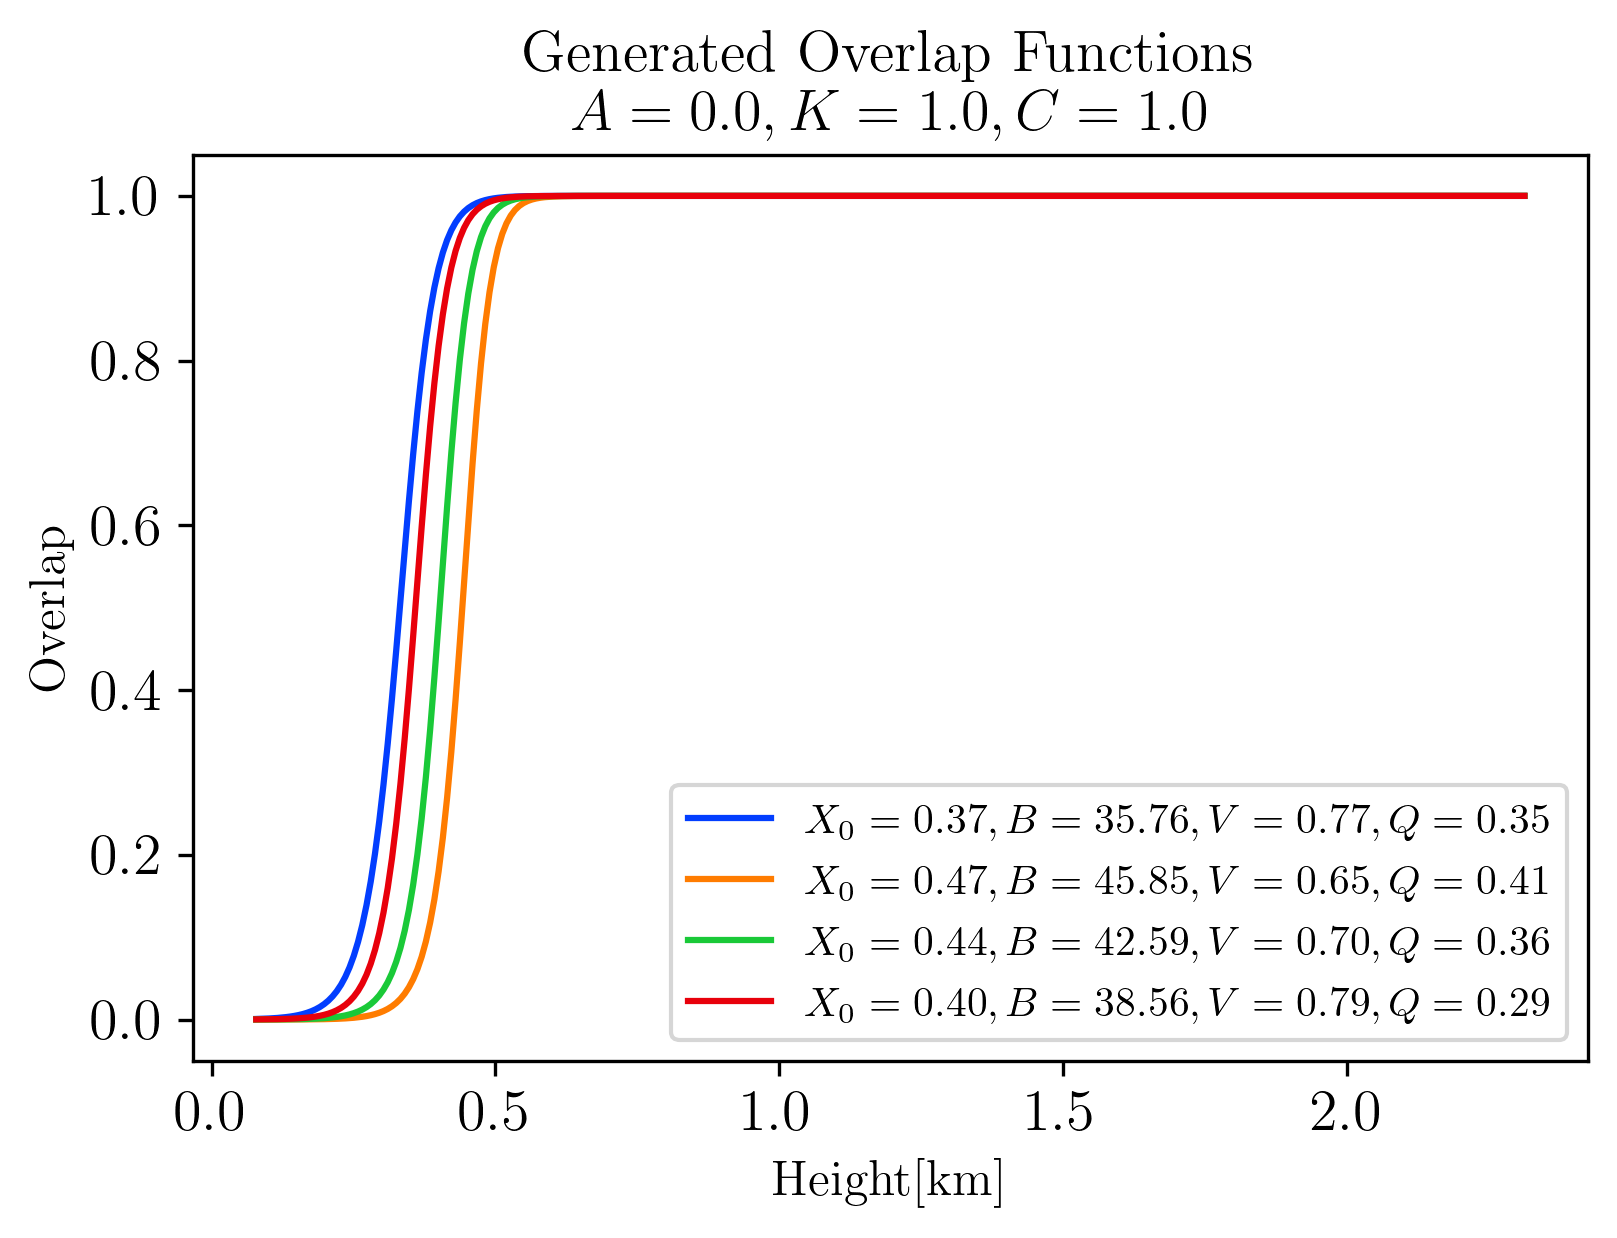

In [12]:
start_date = datetime(2017, 4, 1)
end_date = datetime(2017, 5, 31, 23, 59, 30)
freq_D = 30
freq_stype = 'D'
#assert
delta_days = end_date - start_date
assert delta_days.days>freq_D, "The frequency defined should be lower then the given period"
df_time = gen_sampling_times(start_date, end_date,freq_D, freq_stype ='D')
# Calculating Bezier paths of the overlap parameters to generate overlap function.
# Set the period for calculating bezier fitting
tslice = slice(df_time.values[0], df_time.values[-1])
t0 = df_time.values[0][0]
t1 = df_time.values[-1][0]
dt0 = utils.dt64_2_datetime(t0)
dt1 = utils.dt64_2_datetime(t1)
difft = (dt1 - dt0)
n_total = difft.days * station.total_time_bins + difft.seconds / station.freq
n_pts = df_time.size
dn_t = int(n_total / (n_pts - 1))
# Initialize the points at times of n_pts
# Set the parametric index in which the interpolation is calculated.
points = np.empty((n_pts, 2))
points[:, 0] = np.array([n * dn_t for n in range(n_pts)])
station_time_index = pd.date_range(start=start_date, end=t1, freq=f'{station.freq}S')
# Set values to interpolate at the original points
df_params = generate_overlap_params(n_samples = n_pts)
keys = df_params.keys()
df_params = df_params.sort_values(keys[0])  # Note: Sort is just to have some gradual change. but this can also not applied (e.g. in summer many changed can accure)

In [15]:
df_params

,$\rm x_0$,$\rm A$,$\rm K$,$\rm B$,$\rm \nu$,$\rm C$,$\rm Q$
0,0.371509,0.0,1.000008,35.764972,0.772953,0.999999,0.350000
3,0.400000,0.0,0.999993,38.563780,0.790244,0.999996,0.289886
2,0.438025,0.0,1.000015,42.587009,0.697031,1.000002,0.364793
1,0.474945,0.0,1.000020,45.845314,0.654166,1.000002,0.411657


In [13]:
# Calculate Bezier path per each parameter
ds_keys = []
for key in keys:
    points[:, 1] = df_params[key]
    path = Bezier.evaluate_bezier(points, dn_t)
    ds_keys.append(xr.Dataset(
                    data_vars={key: ('Time', path[:, 1])},
                    coords={'Time': station_time_index.values}))

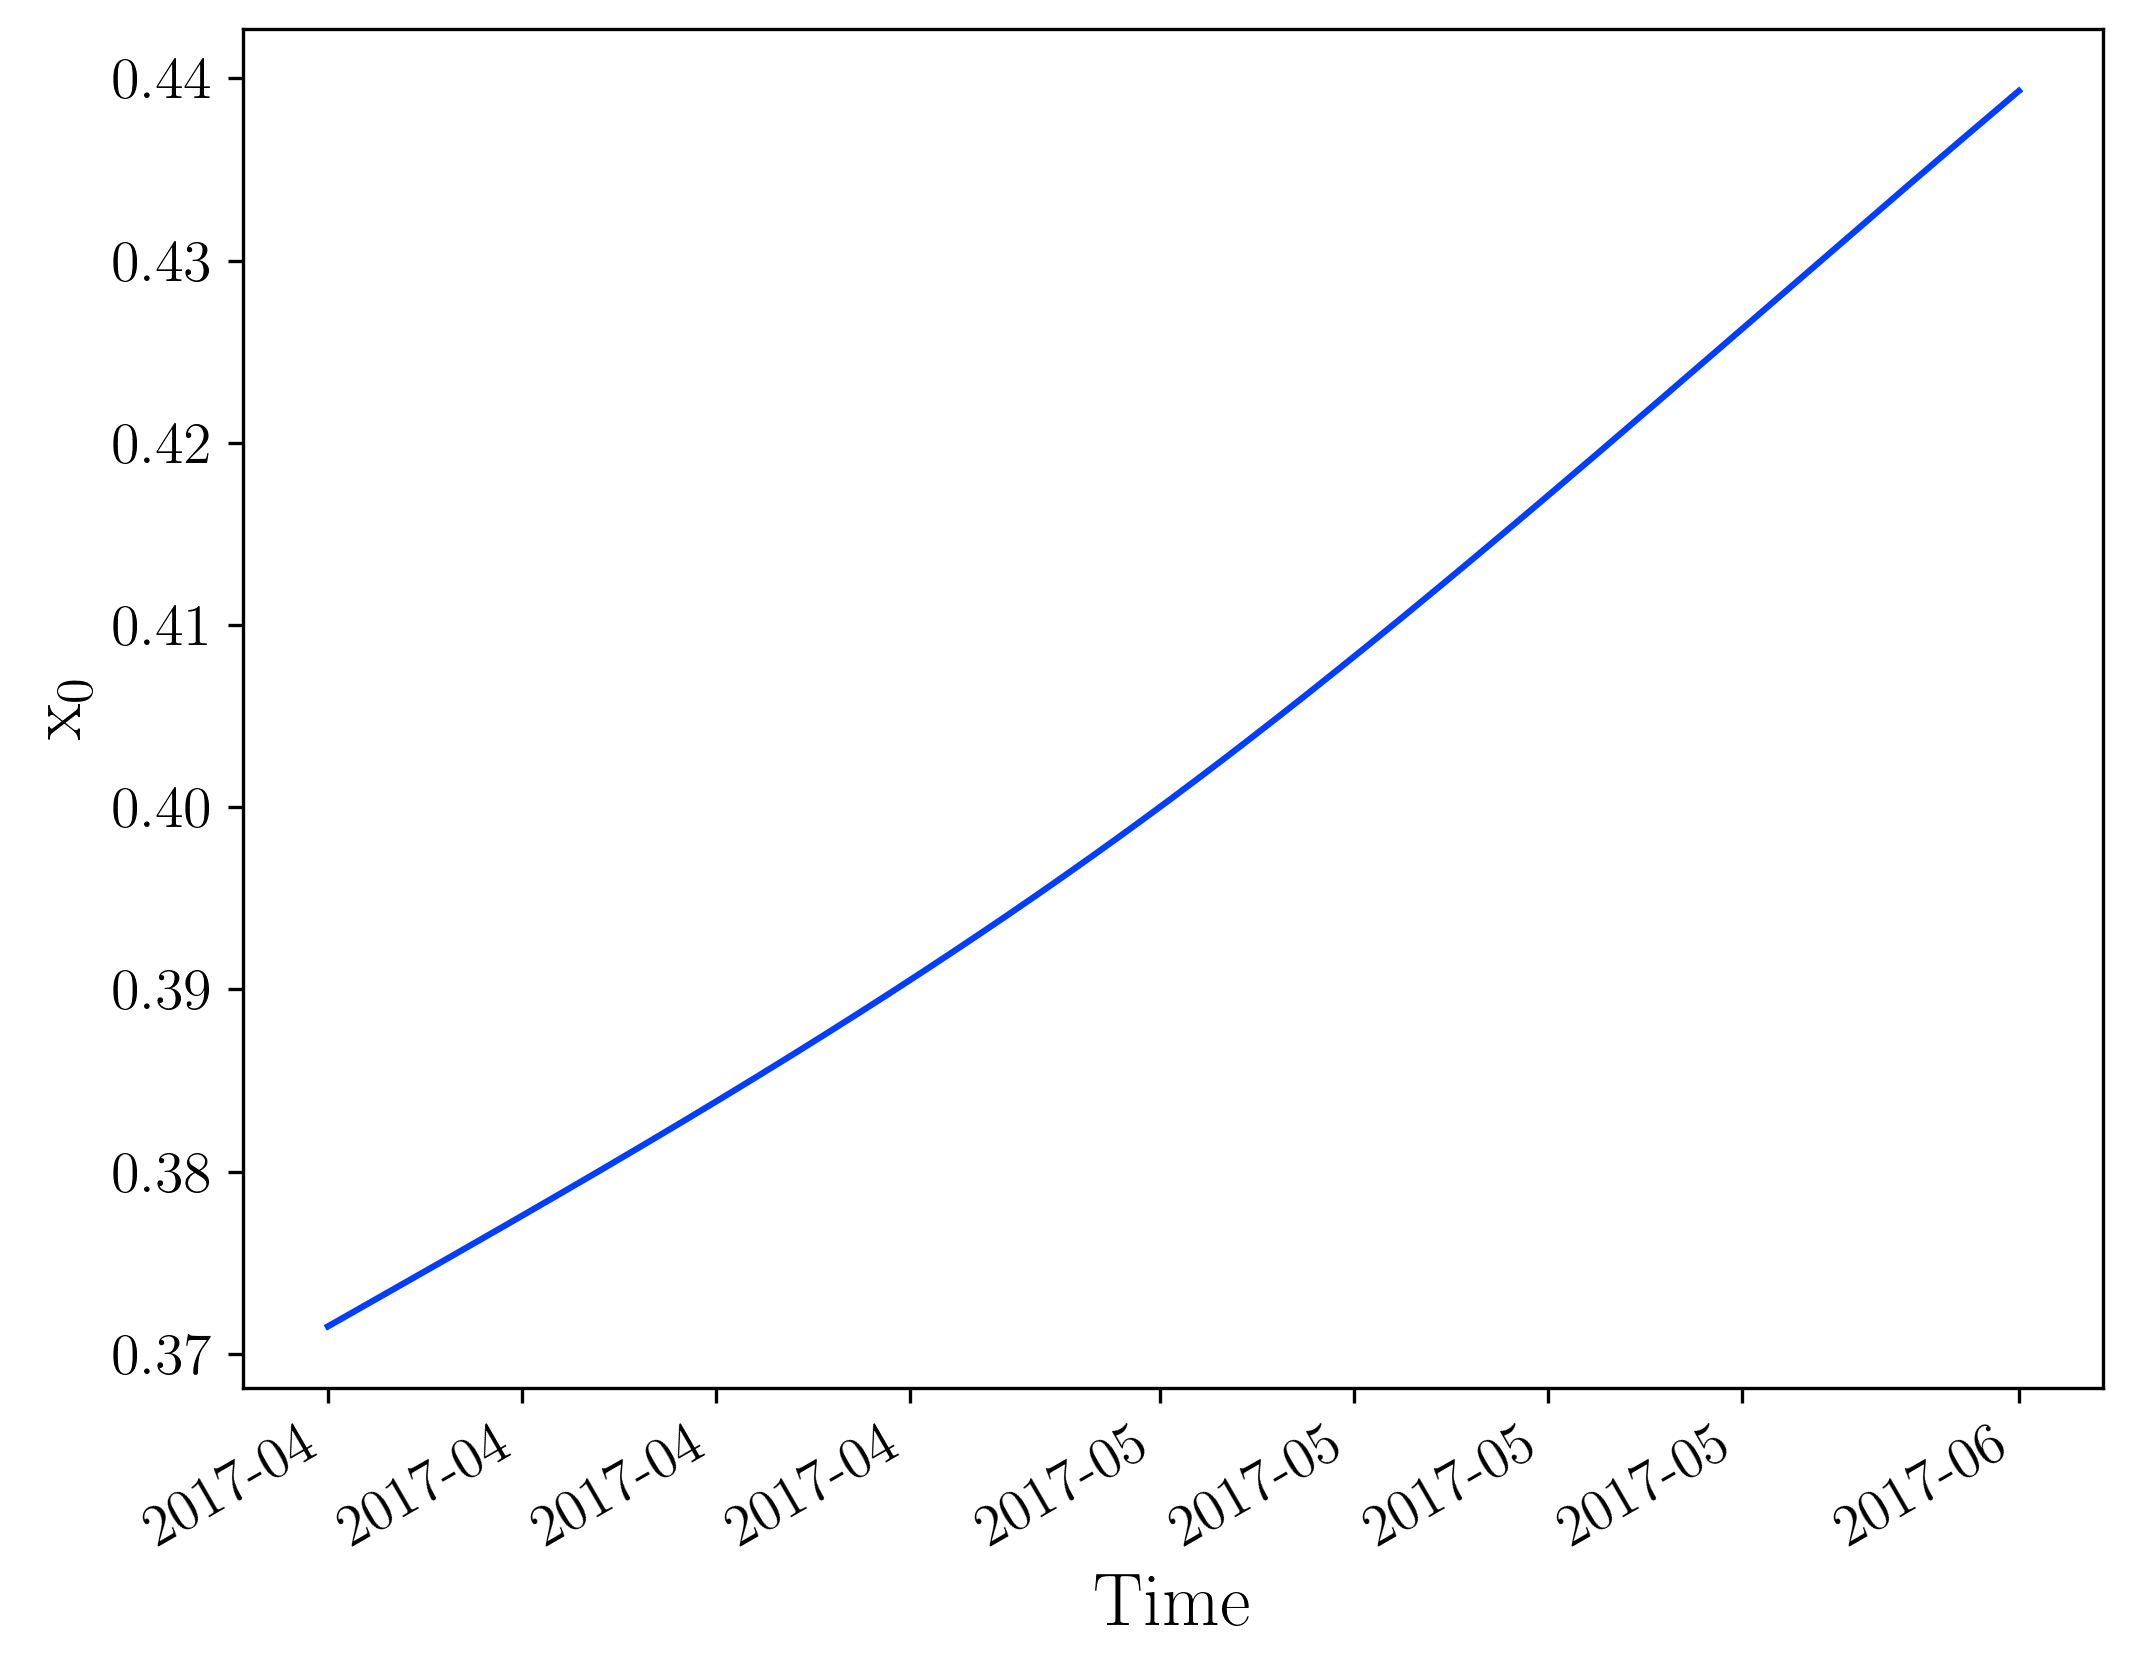

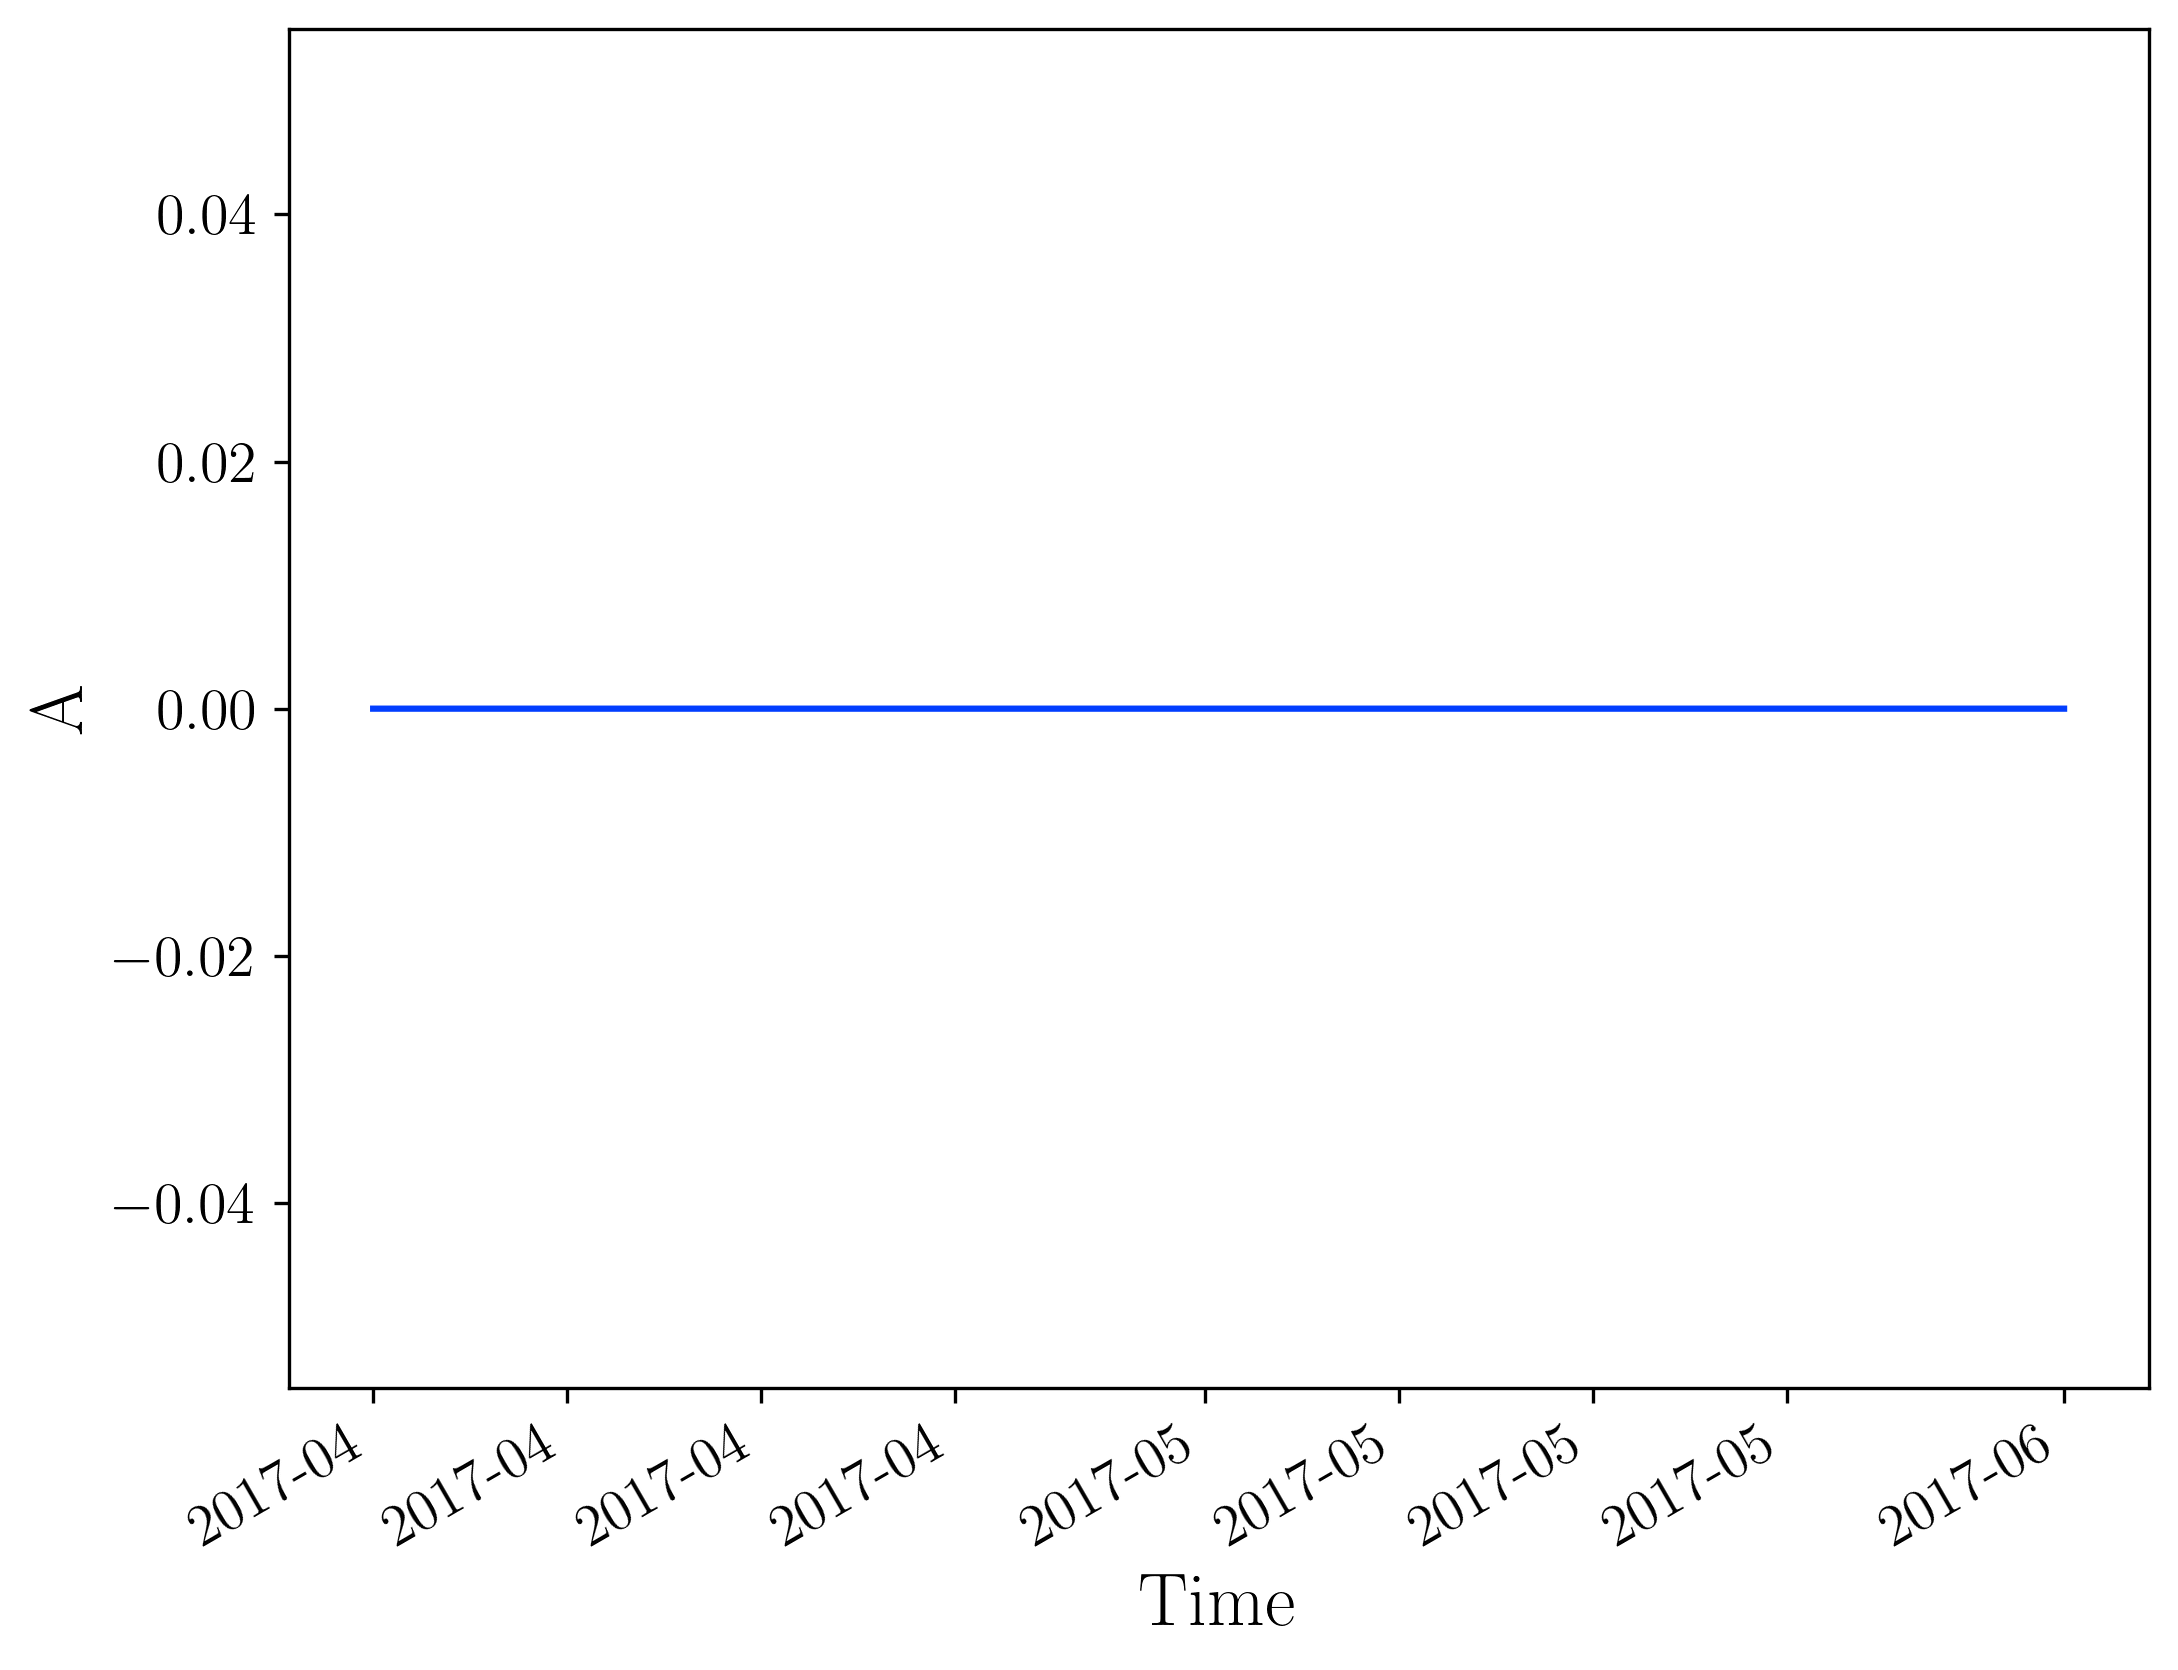

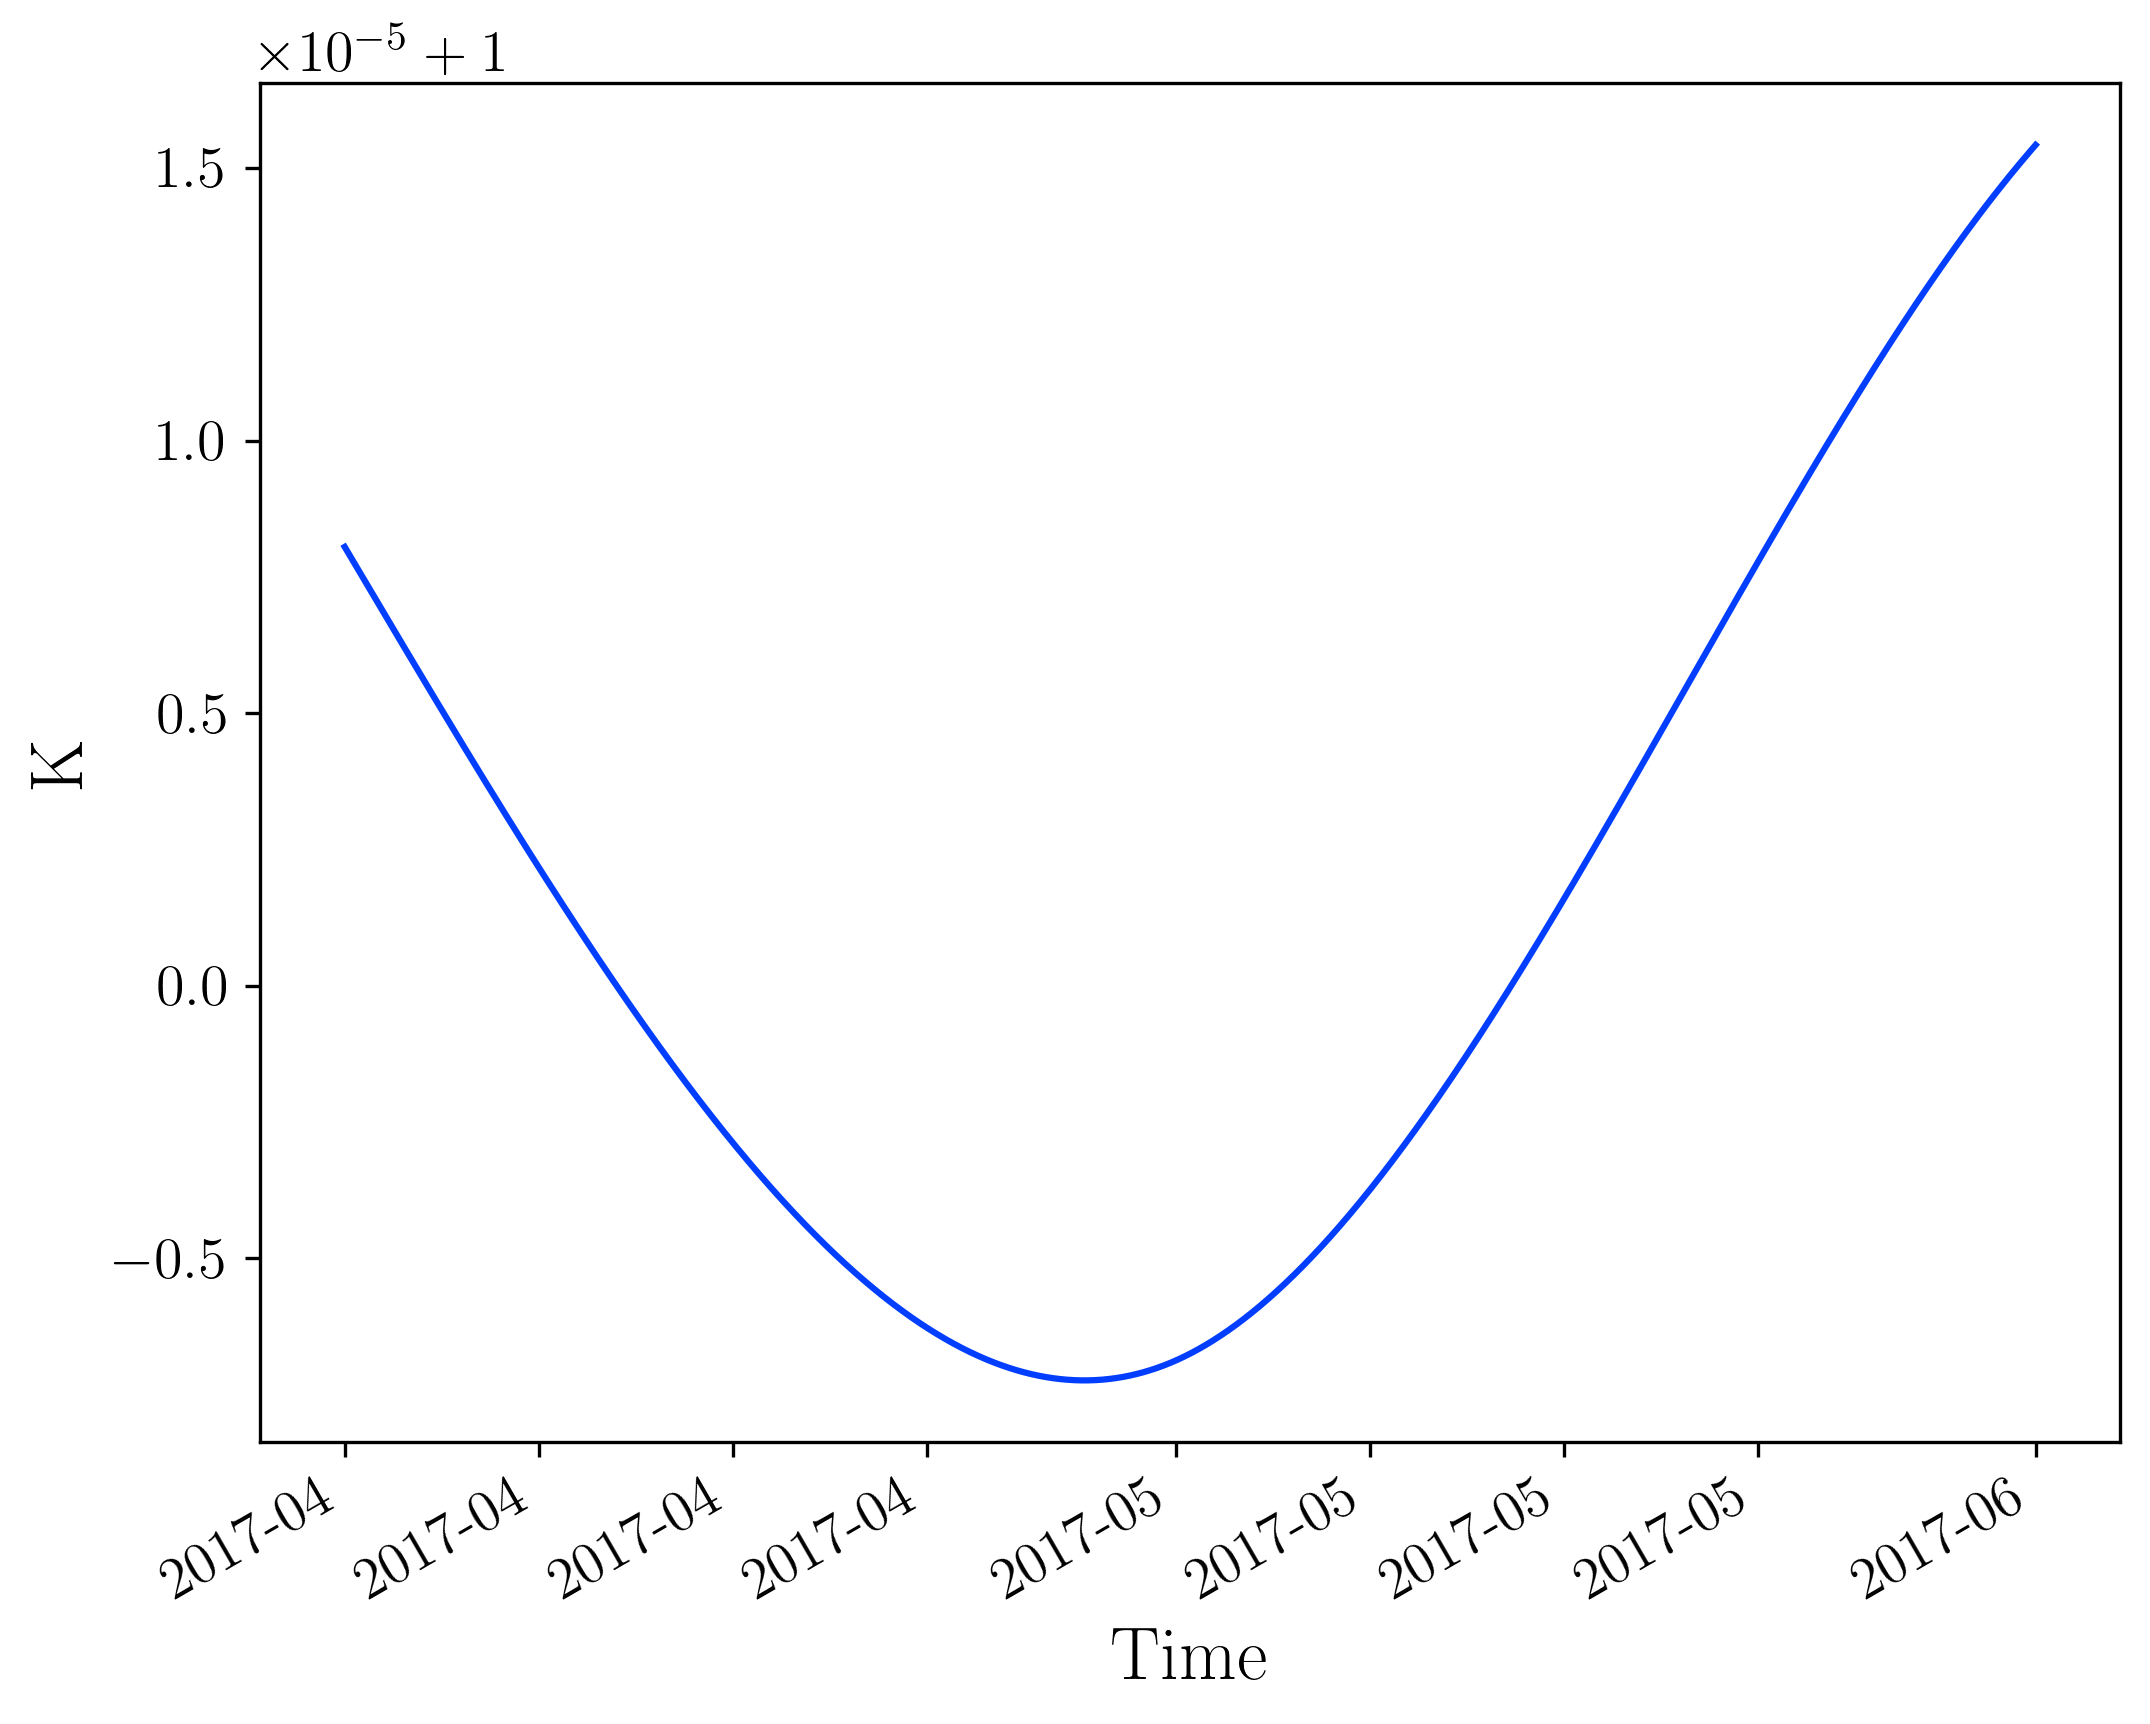

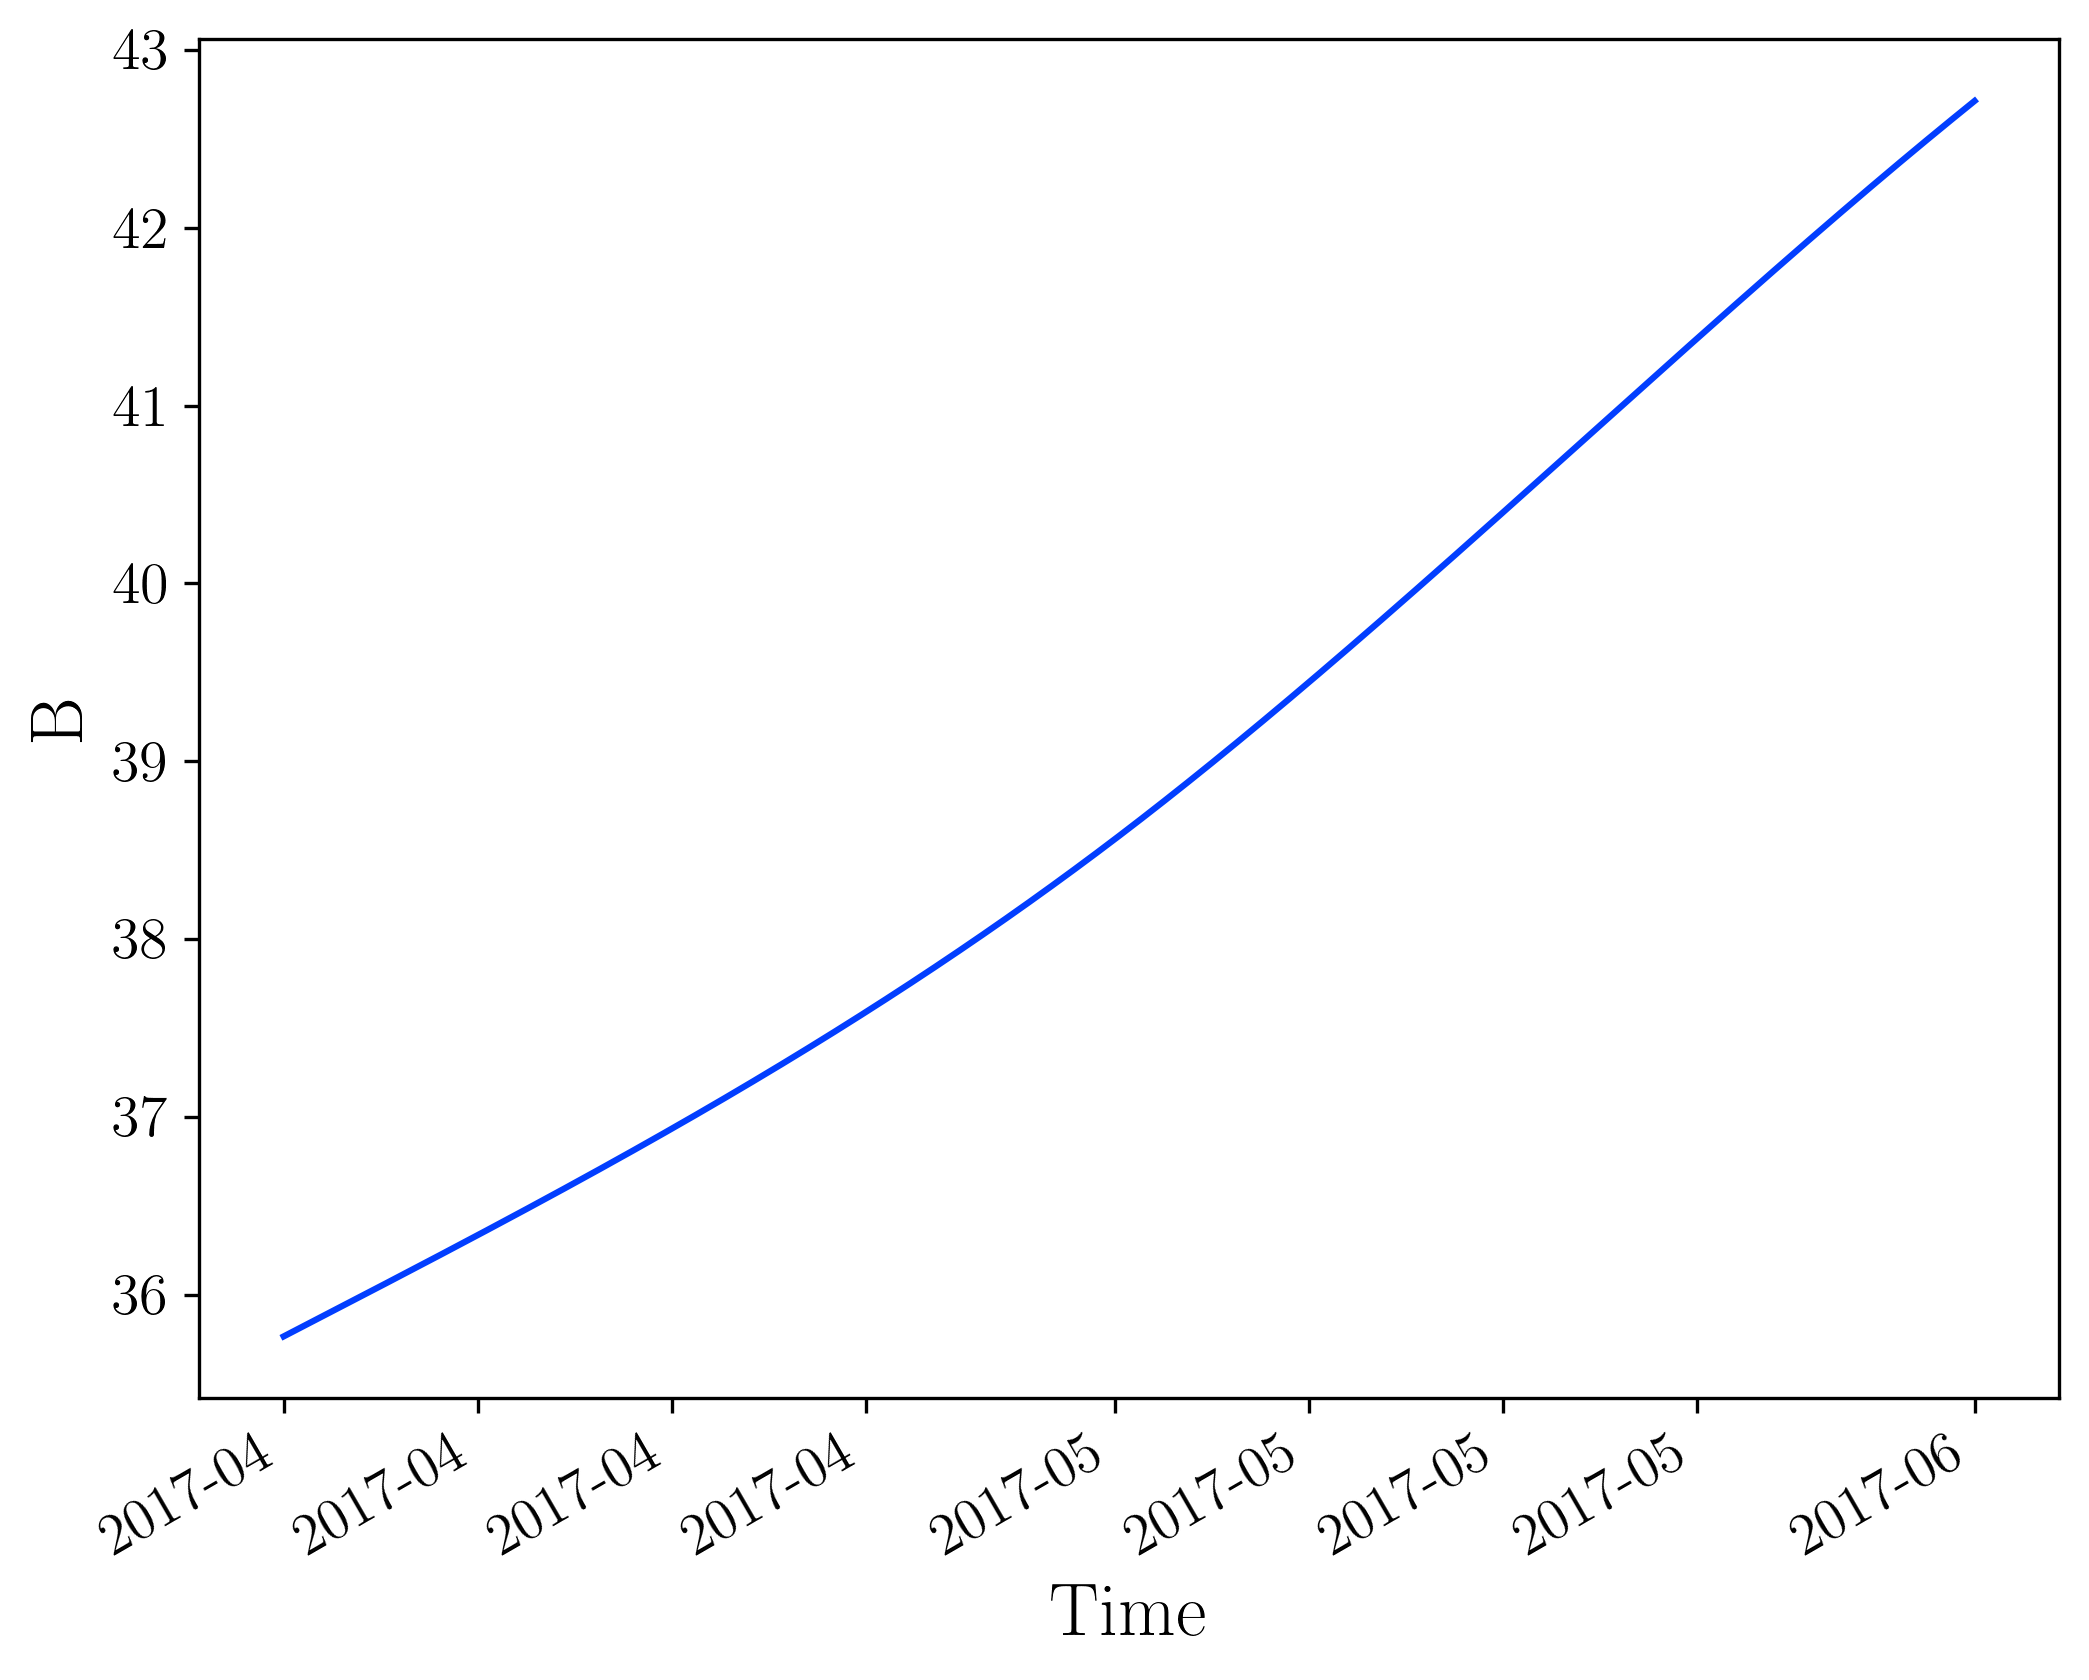

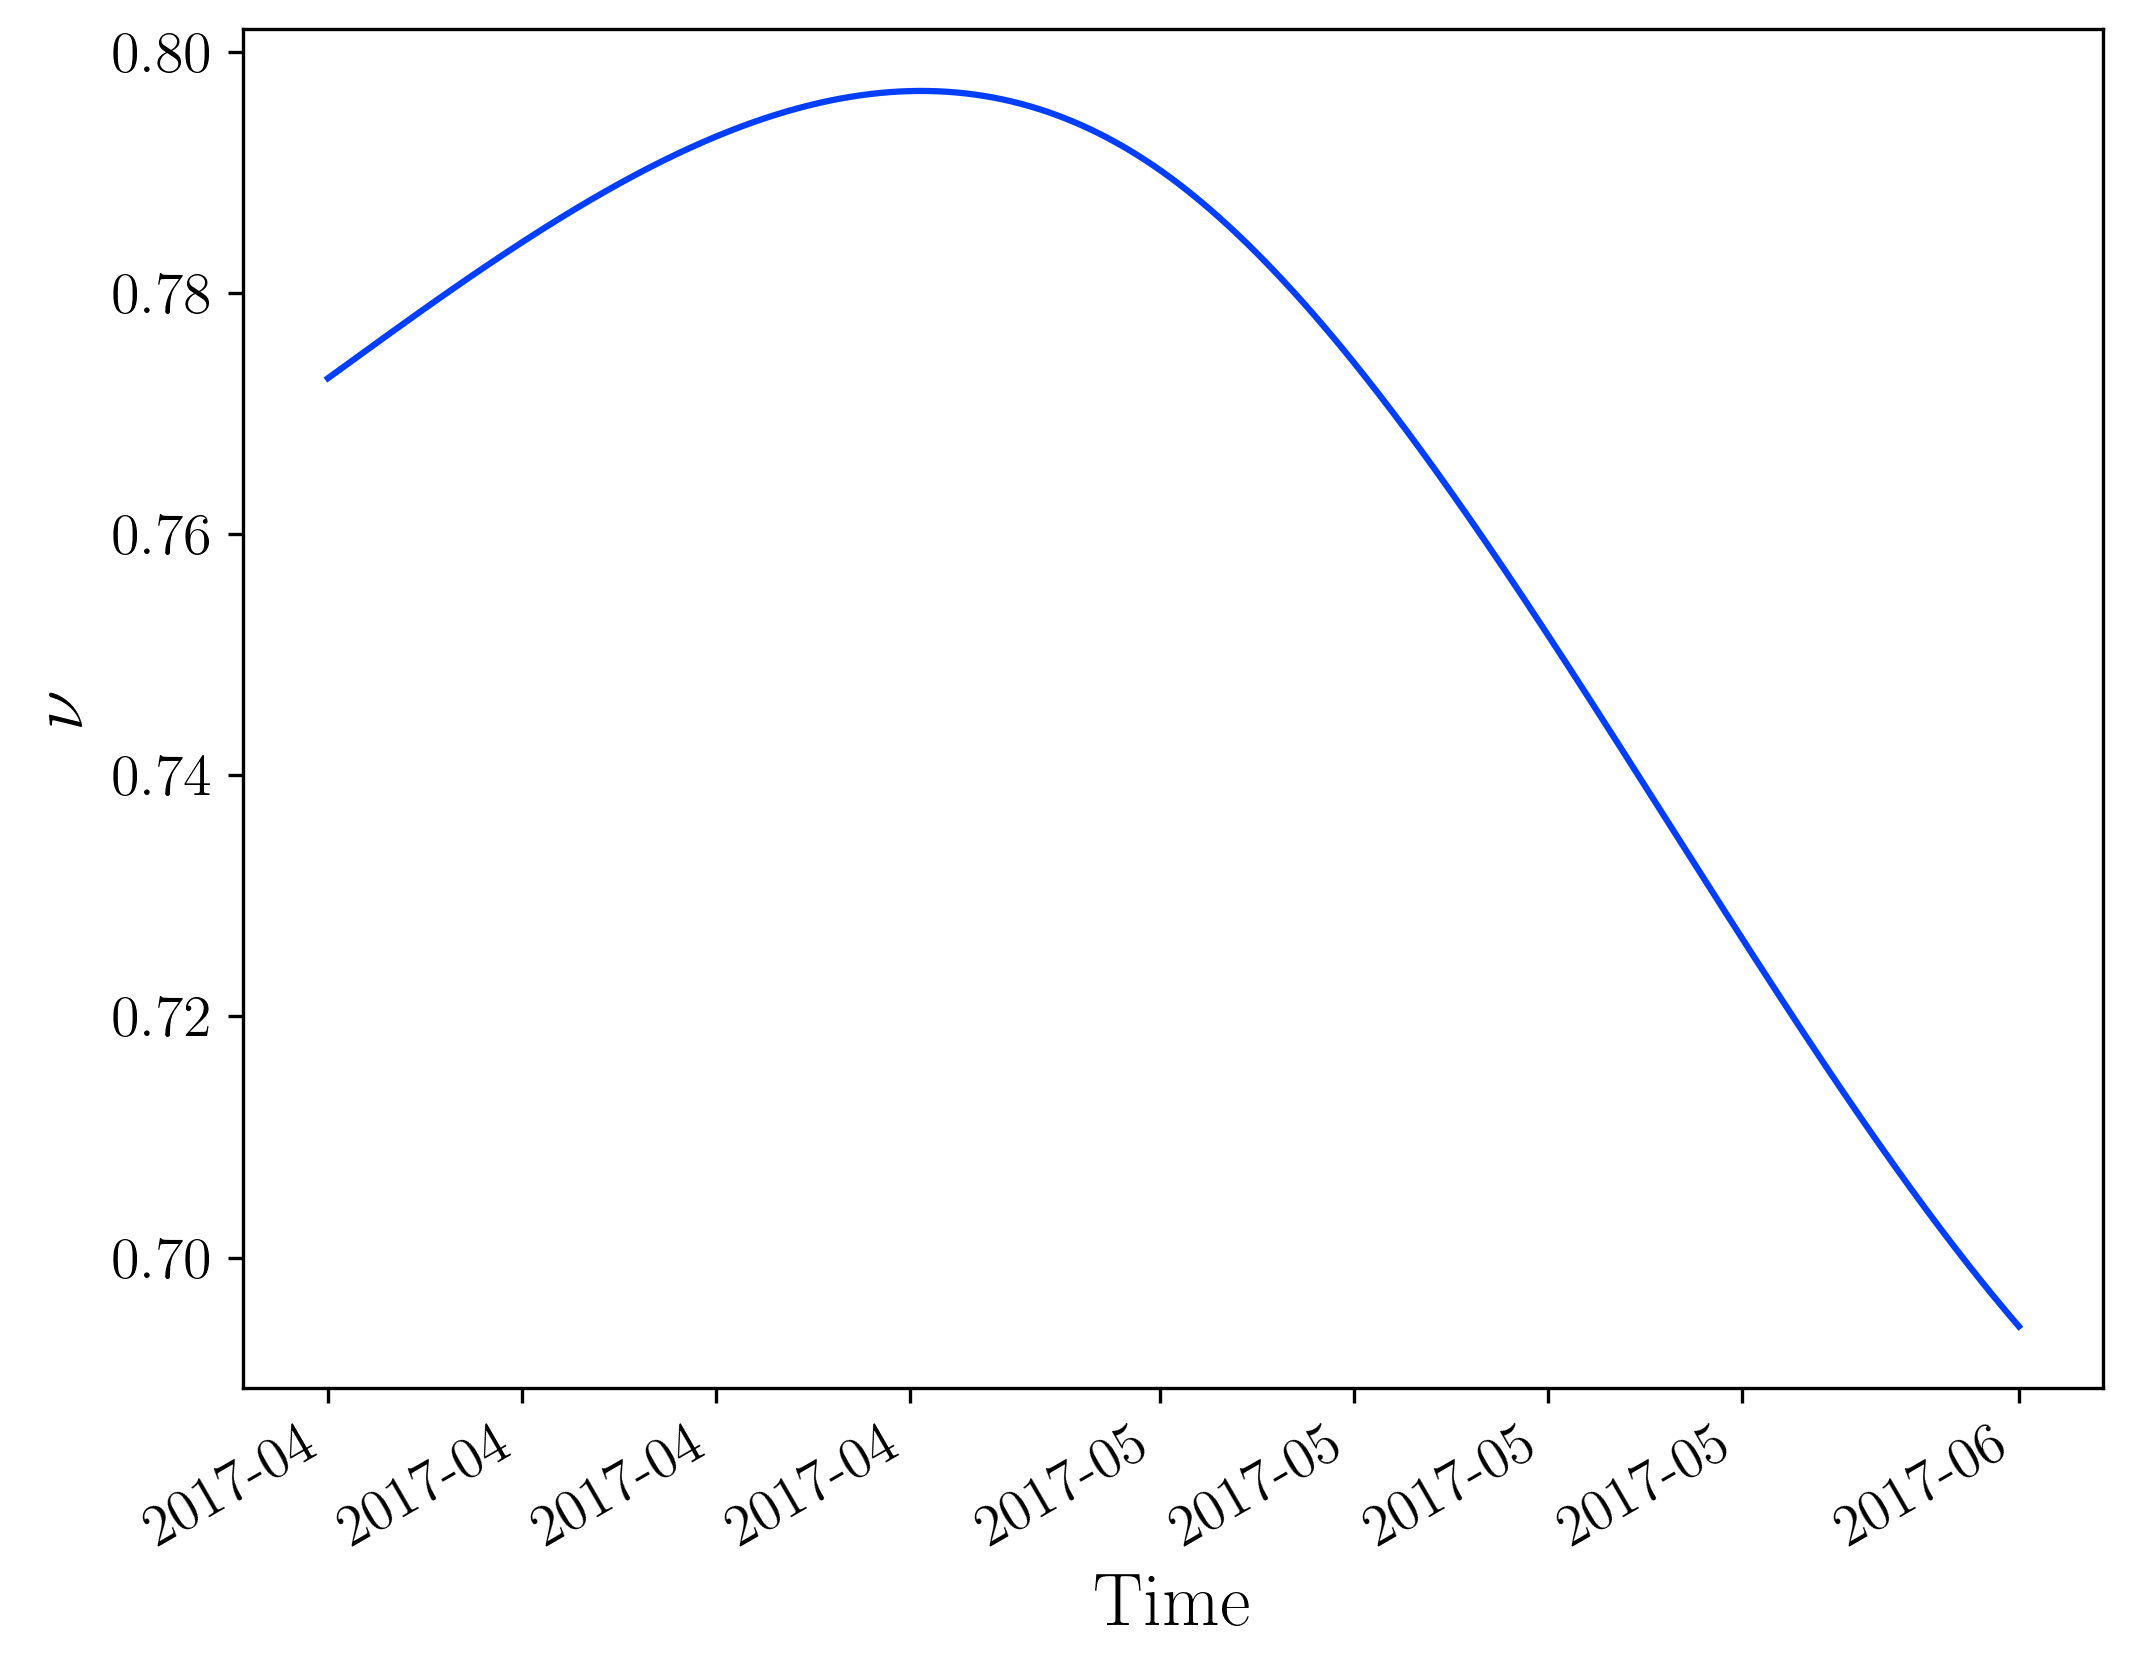

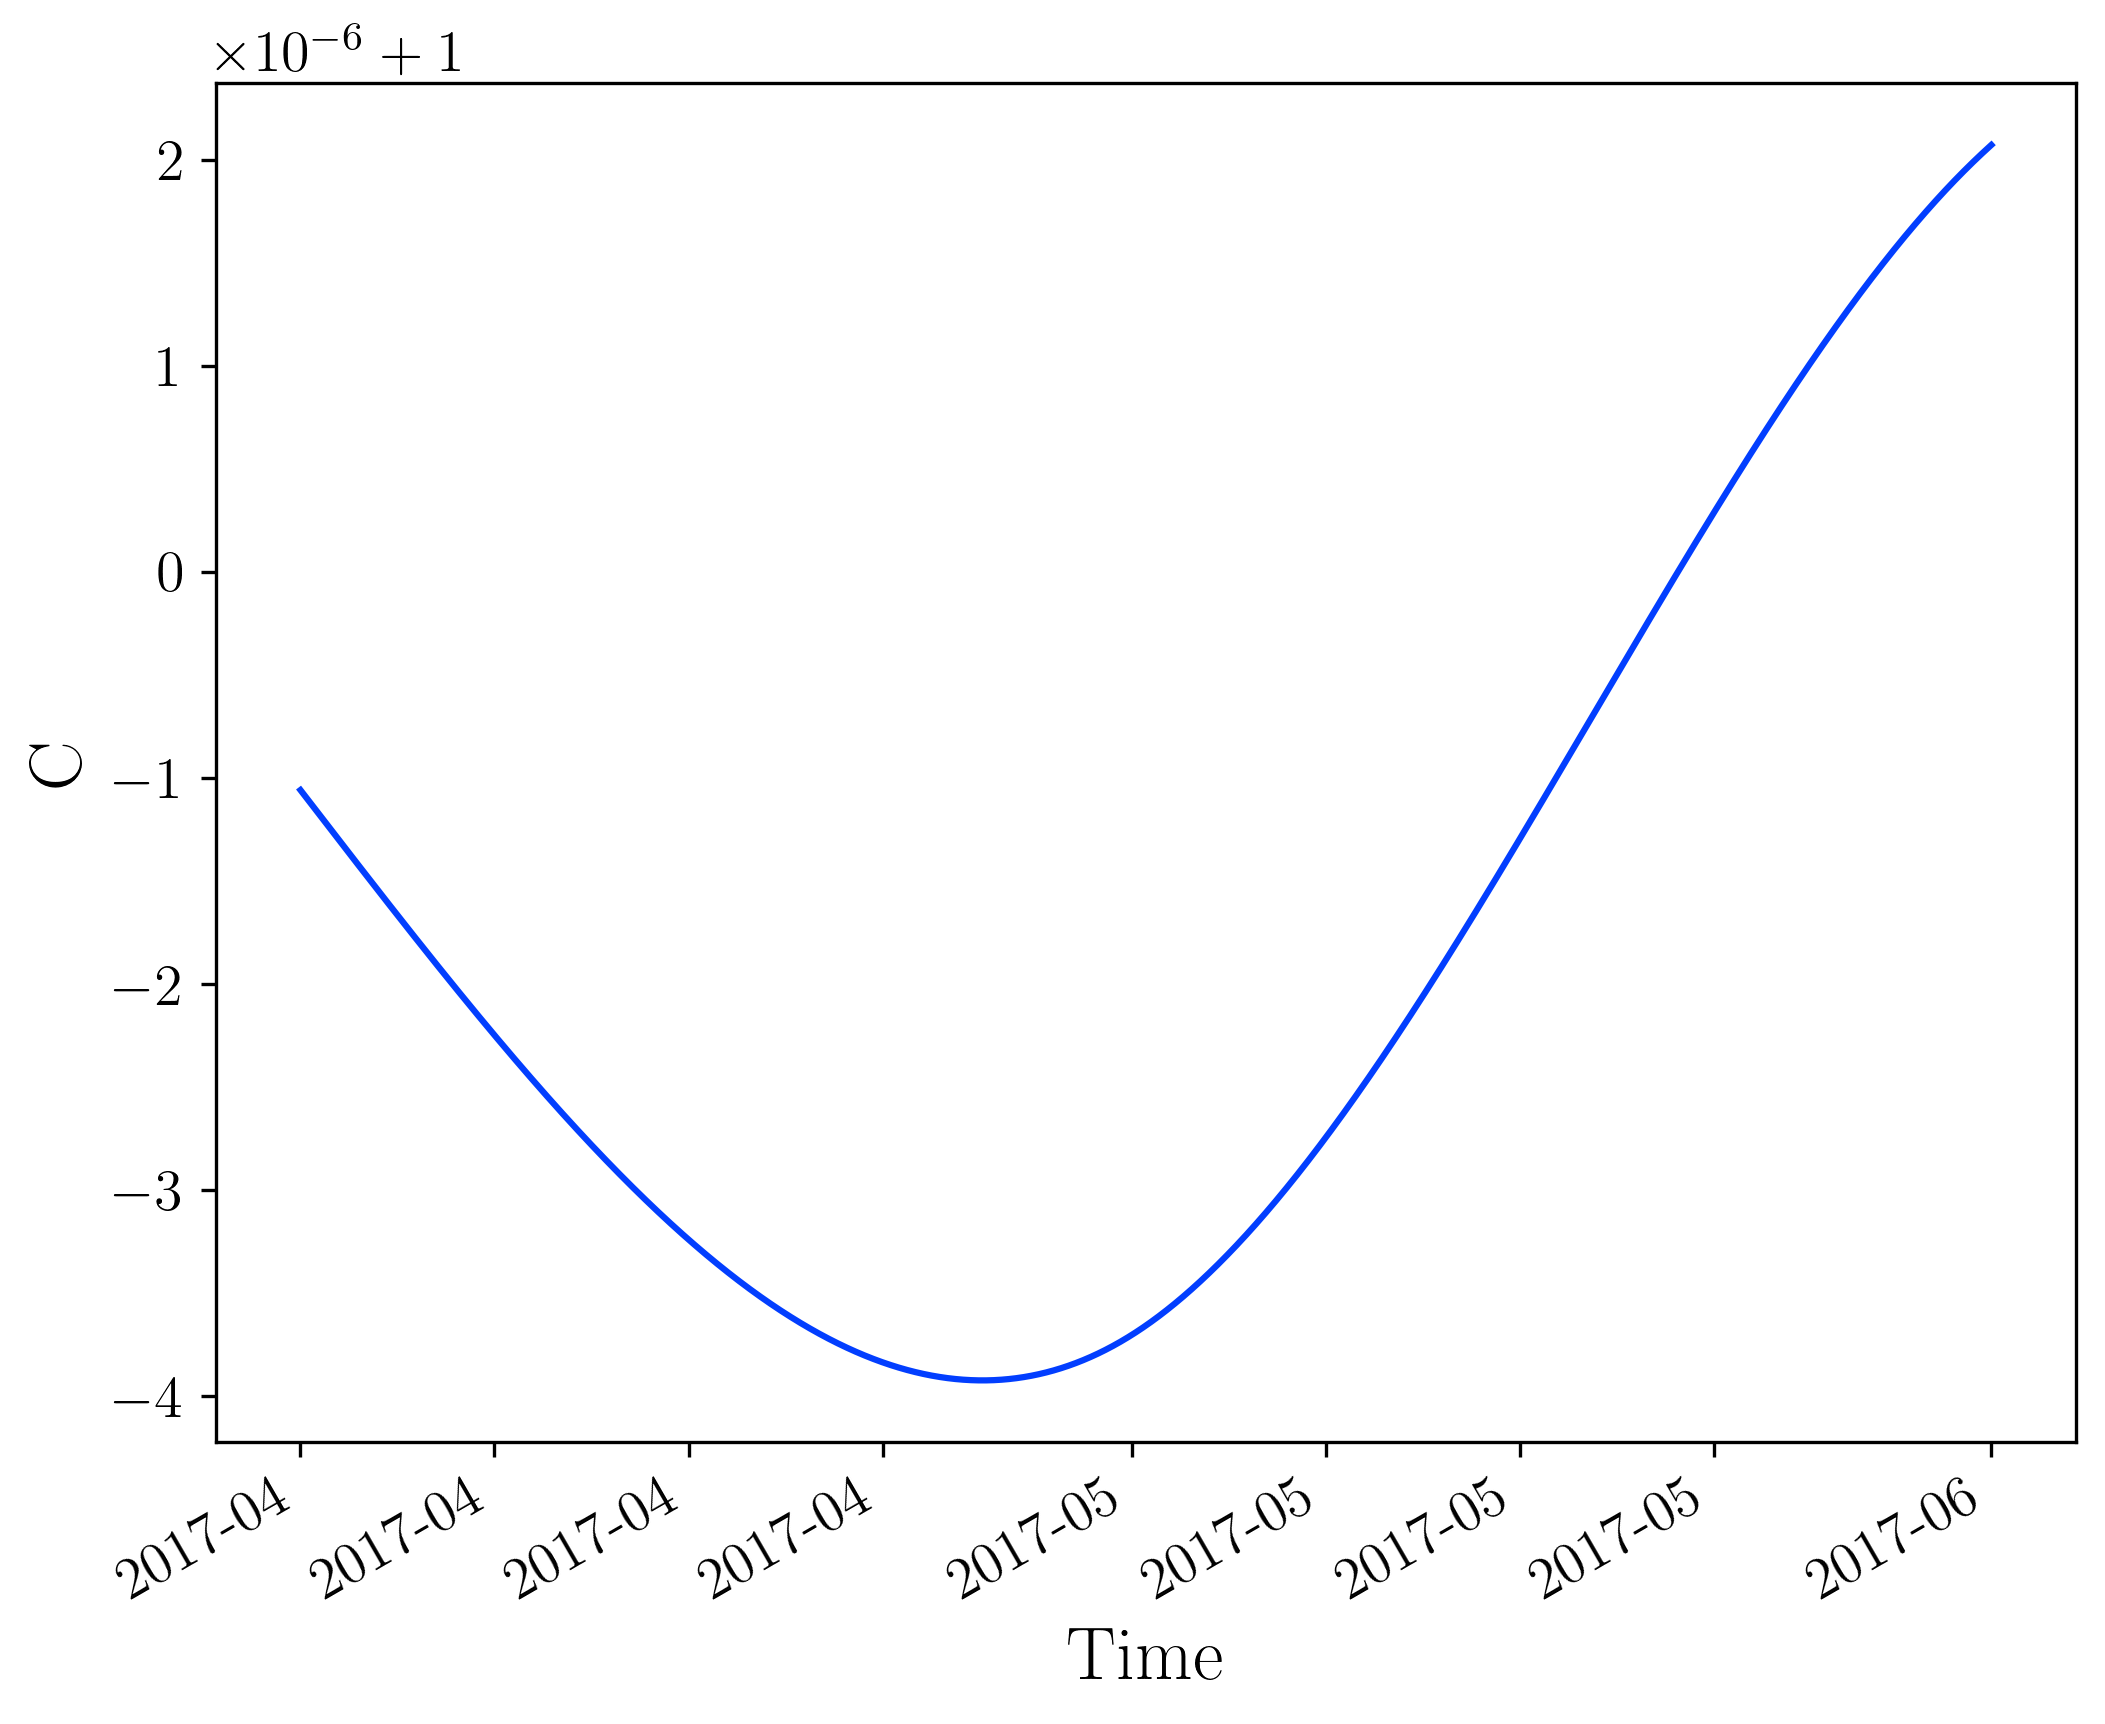

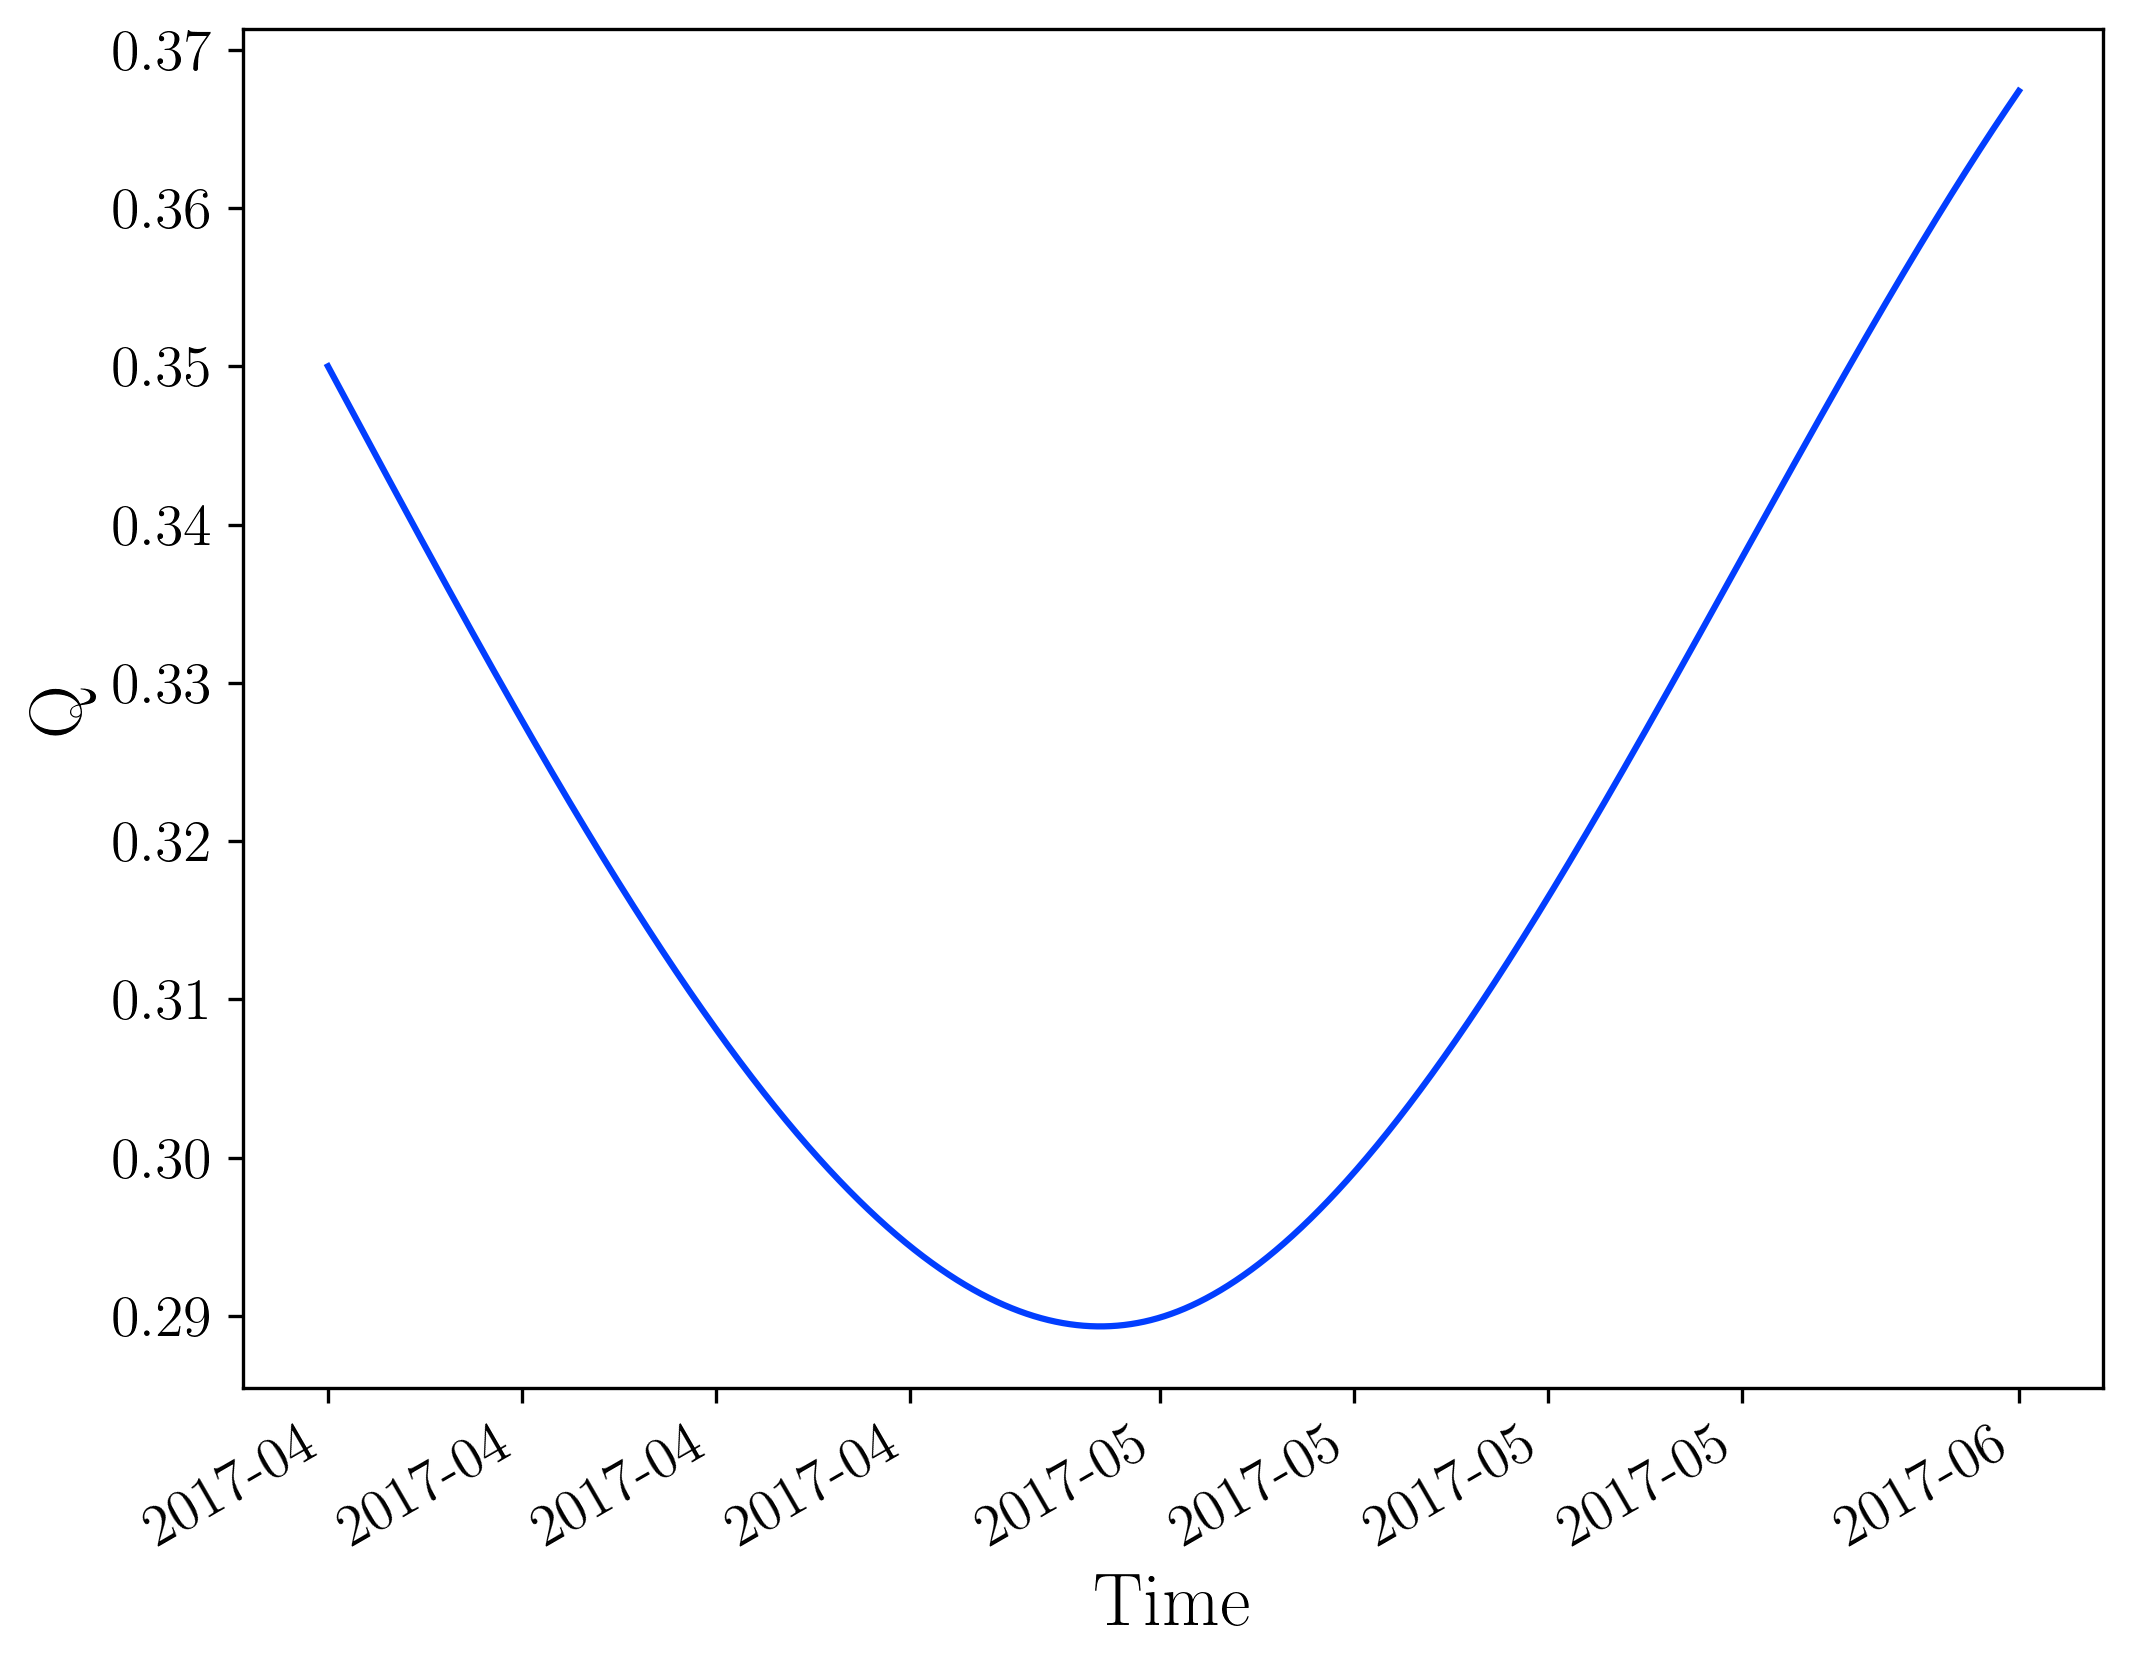

In [14]:
for ds,key in zip(ds_keys,keys):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    ds[key].sel(Time = slice(start_date,end_date)).plot(ax=ax)
    ax.xaxis.set_major_formatter(vis_utils.MONTHFORMAT)
    #ax.xaxis.set_tick_params(rotation=0)
    plt.show()

TODO:
1. Slice the period according to (start_date, end_date) and Save the parametric generation per month.
2. Load parameters for a given period (start_time, end_time) and calculate the overlap function. E.g a day.
3. Apply on generated power p (before adding the b_bg and applying Poisson)
4. Test the CNN